In [1]:
%config InlineBackend.figure_format = "retina"
%load_ext watermark
%watermark
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from collections import OrderedDict
import geopandas
import libpysal
from libpysal import cg, examples
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar
import numpy
import ortools
from ortools.linear_solver import pywraplp
import seaborn
import shapely
from shapely.geometry import Point
import spaghetti
import sys

%matplotlib inline
%watermark -w
%watermark -iv

Last updated: 2022-08-31T23:23:38.199056+09:00

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 8.4.0

Compiler    : MSC v.1928 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 25 Model 33 Stepping 0, AuthenticAMD
CPU cores   : 12
Architecture: 64bit

Watermark: 2.3.1

numpy              : 1.22.4+vanilla
matplotlib         : 3.5.2
ortools            : 9.3.10497
sys                : 3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]
geopandas          : 0.11.0
matplotlib_scalebar: 0.8.1
spaghetti          : 1.6.6
seaborn            : 0.11.2
shapely            : 1.8.2
libpysal           : 4.6.2



c:\Users\chldl\Desktop\공부\공모전\통계데이터활용경진대회\Codespace\statics\lib\site-packages\spaghetti\network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


In [2]:
try:
    from IPython.display import Markdown as md
except ImportError:
    pass

In [3]:
# n clients and n facilities
client_count, facility_count = 400, 14

# candidate facilites to site
p_facilities = 3

# maximum coverage meters
max_coverage = 1000.0

# minimum coverage meters
min_coverage = 800.0

random_seeds = {"client": 3006, "facility": 1520}

title = "Neighborhood X"

## Define a class and functions for solving the models and analyzing the results¶

In [4]:
class FacilityLocationModel:
    """Solve a facility location optimization model

    Parameters
    ----------
    name : str
        Problem model name; must also be defined as a class method.
    cij : numpy.ndarray
        cost matrix from origins (index of i) to destination (index of j).
        Default is None.
    ai : numpy.ndarray
        Client weight vector. Default is None.
    s : float
        service radius. Default is None.
    p : int
        Density of facilities to site. Default is None.
    write_lp : str
        file name (and path) of the LP file to write out.
    print_sol : bool
        print select results. Default is True.

    Methods
    -------
    build_lscp : build location set covering problem
    build_pmp : build p-median problem
    build_pcp : build p-center problem
    build_mclp : build maximal covering location problem
    add_vars : add variables to a model
    add_constrs : add contraints to a model
    add_obj : add an objective function to a model
    optimize : solve a model
    record_decisions : record optimal decision variables
    non_obj_vals : record non-objective values stats (eg. percent covered)
    print_results : print selected results

    Attributes
    ----------
    model : ortools.linear_solver.pywraplp.Solver
        proxy of <Swig Object of type 'operations_research::MPSolver *'
    n_cli : int
        total client sites
    r_cli : range
        iterable of client sites
    n_fac : int
        total candidate facility sites
    r_fac : range
        iterable of candidate facility sites
    aij : numpy.ndarray
        binary coverage matrix from cij (within s service radius)
    sij : numpy.ndarray
        demand weighted cost matrix as (ai * cij).
    fac_vars : dict
        facility decision variables
    cli_vars : dict
        client decision variables
    W : ortools.linear_solver.pywraplp.Variable
        minimized maximum variable in the p-center problem formulation
    lp_formulation : str
        linear programming formulation of the model
    solve_minutes : float
        solve time in minutes
    obj_val : int or float
        model objective value
    fac2cli : dict
        facility to client relationship lookup
    cli2fac : dict
        client to facility relationship lookup
    fac2iloc : dict
        facility to dataframe index location lookup
    n_cli_uncov : int
        count of client location outside the service radius
    cli2ncov : dict
        client to covered by count lookup
    ncov2ncli : dict
        covered by count to client count lookup
    mean_dist :
        mean distance per person to the assigned facility
    perc_served :
        percentage of weighted clients covered in `s`
    """

    def __init__(
        self, name, ai=None, cij=None, s=None, p=None, write_lp=None, print_sol=True
    ):
        # Set model information
        self.name = name
        # create a solver instance
        solver_instance = pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING
        # instantiate a model
        self.model = pywraplp.Solver(self.name, solver_instance)

        # Set parameters and indices
        # facility parameter
        if p:
            self.p = p
        # client count and range
        self.cij = cij
        self.n_cli = cij.shape[0]
        self.r_cli = range(self.n_cli)
        # facility count and range
        self.n_fac = self.cij.shape[1]
        self.r_fac = range(self.n_fac)
        # demand parameter
        if ai is not None:
            self.ai = ai
            self.ai_sum = ai.sum()
            # weighted demand
            try:
                self.sij = self.ai * self.cij
            except ValueError:
                self.ai = self.ai.values.reshape(self.n_cli, 1)
                self.sij = self.ai * self.cij
        # if the model has a service radius parameter
        if s:
            self.s = s
            # binary coverage matrix from cij
            self.aij = numpy.zeros(self.cij.shape)
            self.aij[self.cij <= self.s] = 1.0

        # Set decision variables, constraints, and objective function
        try:
            getattr(self, "build_" + self.name)()
        except:
            raise AttributeError(self.name, "not a defined location model.")

        # solve
        self.optimize(write_lp=write_lp)
        # records seleted decision variables
        self.record_decisions()
        # record non-objective values stats (eg. percent covered)
        self.non_obj_vals()
        # print results
        if print_sol:
            self.print_results()

    def build_lscp(self):
        """ Integer programming formulation of the Location Set Covering Problem.
        Originally Published:
            Toregas, C. and ReVelle, Charles. 1972.
            Optimal Location Under Time or Distance Constraints.
            Papers of the Regional Science Association. 28(1):133 - 144.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=1)  # set coverage constraints
        # Objective Function
        self.add_obj()

    def build_pmp(self):
        """Integer programming formulation of the p-median Problem.
        Originally Published:
            S. L. Hakimi. 1964. Optimum Locations of Switching Centers and
            the Absolute Centers and Medians of a Graph. Operations Research.
            12 (3):450-459.
        Adapted from:
                -1-
            ReVelle, C.S. and Swain, R.W. 1970. Central facilities location.
            Geographical Analysis. 2(1), 30-42.
                -2-
            Toregas, C., Swain, R., ReVelle, C., Bergman, L. 1971. The Location
            of Emergency Service Facilities. Operations Research. 19 (6),
            1363-1373.
                - 3 -
            Daskin, M. (1995). Network and discrete location: Models, algorithms,
            and applications. New York: John Wiley and Sons, Inc.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=2)  # assignment constraints
        self.add_constrs(constr=3)  # facility constraint
        self.add_constrs(constr=4)  # opening constraints
        # Objective Function
        self.add_obj()

    def build_pcp(self):
        """Integer programming formulation of the p-center Problem.
        Originally Published:
            S. L. Hakimi. 1964. Optimum Locations of Switching Centers and
            the Absolute Centers and Medians of a Graph. Operations Research.
            12 (3):450-459.
        Adapted from:
            Daskin, M. (1995). Network and discrete location: Models, algorithms,
            and applications. New York: John Wiley and Sons, Inc.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=2)  # assignment constraints
        self.add_constrs(constr=3)  # facility constraint
        self.add_constrs(constr=4)  # opening constraints
        self.add_constrs(constr=5)  # minimized maximum constraints
        # Objective Function
        self.add_obj()

    def build_mclp(self):
        """Integer programming formulation of the Maximal Covering Location Problem.
        Originally Published:
            Church, R. L and C. ReVelle. 1974. The Maximal Covering Location
            Problem. Papers of the Regional Science Association. 32:101-18.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=3)  # facility constraint
        self.add_constrs(constr=6)  # maximal coverage constraints
        # Objective Function
        self.add_obj()

    def add_vars(self):
        """Add variables to a model."""
        # facility decision variables
        self.fac_vars = {j: self.model.IntVar(0, 1, "y[%i]" % (j)) for j in self.r_fac}
        # client decision variables
        if self.name == "mclp":
            self.cli_vars = {
                (i): self.model.IntVar(0, 1, "x[%i]" % (i)) for i in self.r_cli
            }
        if self.name == "pmp" or self.name == "pcp":
            self.cli_vars = {
                (i, j): self.model.IntVar(0, 1, "x[%i,%i]" % (i, j))
                for i in self.r_cli
                for j in self.r_fac
            }
        # minimized maximum variable
        if self.name == "pcp":
            self.W = self.model.NumVar(0, self.model.infinity(), "W")

    def add_constrs(self, constr=None):
        """ Add constraints to a model.
        (1) set coverage constraints
                y1 + x2 >= 1
                x1 + x3 >= 1
                x2 >= 1
        (2) assignment constraints
                x1_1 + x1_2 + x1_3 = 1
        (3) facility constraints
                y1 + y2 + y3 = p
        (4) opening constraints
                - x1_1 + y1 >= 0
                - x2_1 + y1 >= 0
                - x3_1 + y1 >= 0
        (5) minimax constraints
                cost1_1*x1_1 + cost1_2*x1_2 + cost1_3*x1_3 - W <= 0
        (6) maximal coverage constraints
                - x1 + y1 + y3 >= 0
                - x2 + y4 >= 0
        Parameters
        ----------
        constr : int {1, 2, 3, 4, 5, 6}
            Contraint type to add to model. See above for explanation.
            Default is None.
        """
        # 1 - set covering constraints
        if constr == 1:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum(
                        [self.aij[i, j] * self.fac_vars[j] for j in self.r_fac]
                    )
                    >= 1
                )
        # 2 - assignment constraints
        elif constr == 2:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum([self.cli_vars[i, j] for j in self.r_fac]) == 1
                )
        # 3 - facility constraint
        elif constr == 3:
            self.model.Add(
                self.model.Sum([self.fac_vars[j] for j in self.r_fac]) == self.p
            )
        # 4 - opening constraints
        elif constr == 4:
            for i in self.r_cli:
                for j in self.r_fac:
                    self.model.Add(self.fac_vars[j] - self.cli_vars[i, j] >= 0)
        # 5 - minimax constraints
        elif constr == 5:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum(
                        [self.cij[i, j] * self.cli_vars[i, j] for j in self.r_fac]
                    )
                    <= self.W
                )
        # 6 - max coverage constraints
        elif constr == 6:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum(
                        [self.aij[i, j] * self.fac_vars[j] for j in self.r_fac]
                    )
                    >= self.cli_vars[i]
                )

    def add_obj(self):
        """Add an objective function to a model."""
        if self.name == "lscp":
            self.model.Minimize(self.model.Sum([self.fac_vars[j] for j in self.r_fac]))

        elif self.name == "pmp":
            obj = [
                self.sij[i, j] * self.cli_vars[i, j]
                for i in self.r_cli
                for j in self.r_fac
            ]
            self.model.Minimize(self.model.Sum(obj))

        elif self.name == "pcp":
            self.model.Minimize(self.W)

        elif self.name == "mclp":
            obj = [self.ai.flatten()[i] * self.cli_vars[i] for i in self.r_cli]
            self.model.Maximize(self.model.Sum(obj))

    def optimize(self, write_lp=False):
        """ Solve the model.
        Parameters
        ----------
        write_lp : bool
            write out the linear programming formulation
        """

        def _redirect_to_file(self, text):
            """ Write out the model in linear programming format.
            Parameters
            ----------
            text : str
                full lp formulation in str format
            """
            original = sys.stdout
            sys.stdout = open(self.name + ".lp", "w")
            print(text)
            sys.stdout = original

        self.model.Solve()
        # linear programming formulation
        if write_lp:
            self.lp_formulation = self.model.ExportModelAsLpFormat(True)
            self._redirect_to_file(self.lp_formulation)
        # WallTime() in milliseconds
        self.solve_minutes = self.model.WallTime() * 1.66667e-5
        self.obj_val = self.model.Objective().Value()

    def record_decisions(self):
        """Record decision variable relationship following optimization."""
        # facility-to-dataframe index location lookup
        self.fac2iloc = {v.name(): k for k, v in self.fac_vars.items()}
        # client-to-dataframe index location lookup
        self.cli2iloc = {}
        # facility-to-client lookup
        self.fac2cli = {}

        # record client/service relationships
        for j in self.r_fac:
            if self.fac_vars[j].solution_value() > 0:
                jvar = self.fac_vars[j].name()
                self.fac2cli[jvar] = []
                for i in self.r_cli:
                    ivar = None
                    if self.name == "lscp":
                        if self.aij[i, j] > 0:
                            ivar = "x[%i]" % i
                            self.fac2cli[jvar].append(ivar)
                    elif self.name == "mclp":
                        if self.cli_vars[i].solution_value() > 0:
                            if self.aij[i, j] > 0:
                                ivar = self.cli_vars[i].name()
                                self.fac2cli[jvar].append(ivar)
                    else:
                        if self.cli_vars[i, j].solution_value() > 0:
                            ivar = self.cli_vars[i, j].name()
                            ivar = ivar.split(",")[0] + "]"
                            self.fac2cli[jvar].append(ivar)
                    if ivar:
                        self.cli2iloc[ivar] = i

        # client-to-facility lookup
        self.cli2fac = {}
        for cv in list(self.cli2iloc.keys()):
            self.cli2fac[cv] = []
            for k, v in self.fac2cli.items():
                if cv in v:
                    self.cli2fac[cv].append(k)

        # count of uncovered clients
        self.n_cli_uncov = self.n_cli - len(self.cli2iloc.keys())

        # clients of clients covered by n facilities
        if self.name == "lscp" or self.name == "mclp":
            self.cli2ncov = {}
            for c, fs in self.cli2fac.items():
                self.cli2ncov[c] = len(fs)
            most_coverage = max(self.cli2ncov.values())
            self.ncov2ncli = {}
            for cov_count in range(most_coverage + 1):
                if cov_count == 0:
                    self.ncov2ncli[cov_count] = self.n_cli_uncov
                    continue
                if not cov_count in list(self.cli2ncov.keys()):
                    self.ncov2ncli[cov_count] = 0
                for c, ncov in self.cli2ncov.items():
                    if ncov >= cov_count:
                        self.ncov2ncli[cov_count] += 1

    def non_obj_vals(self):
        """Record non-objective values."""
        if self.name == "pmp":
            self.mean_dist = self.obj_val / float(self.ai_sum)

        if self.name == "mclp":
            self.perc_served = (self.obj_val / float(self.ai_sum)) * 100.0

    def print_results(self):
        """Print select results."""
        print("Solve Time:", self.solve_minutes, "minutes")

        # solve time and objective value
        if self.name == "lscp":
            u1 = "facilities needed for total coverage within a "
            u2 = "%f meter service radius" % self.s
        if self.name == "pmp":
            u1 = "total weighted distance with "
            u2 = "%i selected facilities" % self.p
        if self.name == "pcp":
            u1 = "worst case distance with "
            u2 = "%i selected facilities" % self.p
        if self.name == "mclp":
            u1 = "residents within %f meters of " % self.s
            u2 = "%i selected facilities" % self.p
        units = u1 + u2

        print("Obj. Value:", self.obj_val, units)

        if self.name == "pmp":
            print("Mean weighted distance per", "person: %f" % self.mean_dist)
        if self.name == "mclp":
            print(
                "Percent of %i" % self.ai_sum, "clients covered: %f" % self.perc_served
            )

        # coverage values
        if self.name == "lscp" or self.name == "mclp":
            for ncov, ncli in self.ncov2ncli.items():
                if ncov == 0:
                    print("--- %i clients are not covered" % ncli)
                else:
                    if ncov == 1:
                        sp = "y"
                    else:
                        sp = "ies"
                    print(
                        "--- %i clients are covered" % ncli,
                        "by %i" % ncov,
                        "facilit" + sp,
                    )
def add_results(model, cli_df, fac_df, print_solution=False):
    """Add decision variable relationships to a dataframe.
    Parameters
    ----------
    model : ortools.linear_solver.pywraplp.Solver
        proxy of <Swig Object of type 'operations_research::MPSolver *'
    cli_df : geopandas.GeoDataFrame
        GeoDataFrame of client locations
    fac_df : geopandas.GeoDataFrame
        GeoDataFrame of facility locations
    print_solution : bool
        print out solution decision variables. Default is False.
    Returns
    -------
    cli_df : geopandas.GeoDataFrame
        updated client locations
    fac_df : geopandas.GeoDataFrame
        updated facility locations
    """
    col_name = model.name + "_sol"
    fillers = [[cli_df, "cli2fac"], [fac_df, "fac2cli"]]
    for df, attr in fillers:
        df[col_name] = df["dv"].map(getattr(model, attr))
        df[col_name].fillna("closed", inplace=True)
    if print_solution:
        selected = fac_df[fac_df[col_name] != "closed"]
        for idx in selected.index:
            print("")
            print(selected.loc[idx, "dv"], "serving:", selected.loc[idx, col_name])
    return cli_df, fac_df

In [5]:
def plotter(
    fig=None,
    base=None,
    plot_aux=None,
    buffered=None,
    model=None,
    pt1_size=None,
    pt2_size=None,
    plot_res=None,
    save_fig=False,
    title=None,
    figsize=(10, 10),
):
    """ Top-level scenario plotter for location analytics.
    Parameters
    ----------
    fig : matplotlib.figure.Figure
        complete figure to plot. Default is None.
    base : matplotlib.axes._subplots.AxesSubplot
        individual axis to plot. Default is None.
    plot_aux : dict
        model data parameters dataframes to plot keyed by
        descriptive names. Default is None.
    plot_res : dict
        model data results dataframes to plot keyed by
        descriptive names. Default is None.
    buffered : see
        buffer distance from roads segments in `plot_base`.
        Default is None.
    pt1_size : float or float
        size of points to plot. `pt1_size` should always be the
        larger between `pt2_size` and `pt1_size`. Default is None.
    pt2_size : float or float
        size of points to plot. Default is None.
    model : ortools.linear_solver.pywraplp.Solver
        proxy of <Swig Object of type 'operations_research::MPSolver *'
    title : str
        plot title. Default is None.
    figsize : tuple
        Figure size for plot. Default is (12,12).
    save_fig : bool
        Default is False.
    Returns
    -------
    add_to_legend : list
        items to add to legend
    """
    for_multiplot = True
    if not fig and not base:
        for_multiplot = False
        fig, base = plt.subplots(1, 1, figsize=figsize)

    # add title
    if not for_multiplot:
        if model:
            title += " - " + model.name
        base.set_title(title, size=20)
    else:
        base.set_title(model.name, size=20)

    # plot non-results data
    if plot_aux:
        for k, df in plot_aux.items():
            if k == "streets":
                df.plot(ax=base, lw=2, edgecolor="k", zorder=1)
            if k == "buffer":
                df.plot(ax=base, facecolor="y", lw=0.25, alpha=0.25, zorder=1)
            if k == "cli_tru":
                if plot_res:
                    df = df[df[model.name + "_sol"] == "closed"]
                    psize = pt2_size / 6.0
                    pcolor = "k"
                else:
                    n_cli = df.shape[0]
                    psize = pt1_size
                    pcolor = "r"
                df.plot(ax=base, markersize=psize, edgecolor="k", facecolor=pcolor)
            if k == "fac_tru":
                if plot_res:
                    df = df[df[model.name + "_sol"] == "closed"]
                    psize = pt2_size
                    pcolor = "k"
                    pmarker = "*"
                else:
                    n_cli = df.shape[0]
                    psize = pt1_size
                    pcolor = "b"
                    pmarker = "o"
                df.plot(
                    ax=base,
                    markersize=psize,
                    edgecolor="k",
                    facecolor=pcolor,
                    marker=pmarker,
                )
                n_fac = df.shape[0]
            if k == "cli_snp":
                df.plot(
                    ax=base,
                    markersize=pt2_size,
                    edgecolor="k",
                    facecolor="r",
                    alpha=0.75,
                )
            if k == "fac_snp":
                df.plot(
                    ax=base,
                    markersize=pt2_size,
                    edgecolor="k",
                    facecolor="b",
                    alpha=0.75,
                )
        add_to_legend = list(plot_aux.keys())
    else:
        add_to_legend = None

    # plot results data
    if plot_res:
        dv_colors = dv_colorset(plot_res["fac_var"].dv)
        # facilities
        df = plot_res["fac_var"][plot_res["fac_var"][model.name + "_sol"] != "closed"]
        alpha = 1.0 / float(len(df.dv) - 2)
        if alpha > 0.5:
            alpha = 0.5
        # decision variable info for legend
        dvs_to_leg = {}
        # plot facilities
        for dv in df.dv:
            fac = df[df.dv == dv]
            fac.plot(
                ax=base,
                marker="*",
                markersize=pt1_size * 3.0,
                alpha=0.8,
                zorder=3,
                edgecolor="k",
                facecolor=dv_colors[dv],
            )
            # update decision variable info with set color
            dvs_to_leg[dv] = {"facecolor": dv_colors[dv]}
        # plot clients & service areas
        for f, c in model.fac2cli.items():
            fc = plot_res["cli_var"][plot_res["cli_var"].dv.isin(c)]
            fc.plot(
                ax=base,
                markersize=50,
                edgecolor="k",
                facecolor=dv_colors[f],
                alpha=alpha,
                zorder=2,
            )
            # update decision variable info with set client counts
            dvs_to_leg[f].update({"clients": fc.shape[0]})
            # create service area polygon
            service_area = concave_hull(df, fc, f)
            service_area.plot(
                ax=base, edgecolor="k", alpha=0.2, facecolor=dv_colors[f], zorder=1
            )
    else:
        dvs_to_leg = None

    if not model:

        class _ShellModel:
            """Object to mimic `model` when not present."""

            def __init__(self, plot_aux):
                try:
                    self.n_cli = plot_aux["cli_tru"].shape[0]
                    try:
                        self.n_fac = plot_aux["fac_tru"].shape[0]
                    except KeyError:
                        pass
                except KeyError:
                    pass

        try:
            model = _ShellModel(plot_aux)
        except (TypeError, KeyError):
            model = None

    if not for_multiplot:
        # create legend patches
        patches = create_patches(
            model=model,
            for_multiplot=for_multiplot,
            pt1_size=pt1_size,
            pt2_size=pt2_size,
            buffered=buffered,
            legend_aux=add_to_legend,
            dvs_to_leg=dvs_to_leg,
        )
        add_legend(patches, for_multiplot=for_multiplot)
    #add_north_arrow(base)
    add_scale(base)

    if save_fig:
        plt.savefig(model.name + ".png")

    # if for a multiplot explicityly return items to add to legend
    if for_multiplot:
        return add_to_legend

In [6]:
def multi_plotter(
    models,
    plot_aux=None,
    plot_res=None,
    select=None,
    title=None,
    figsize=(14, 14),
    shape=(2, 2),
):
    """plot multiple base axes as one figure
    Parameters
    ----------
    models : list
        solved model objects
    select : dict
        facility-to-selection count lookup.
    shape : tuple
        dimension for subplot array. Default is (2,2).s
    plot_aux : see plotter()
    plot_res : see plotter()
    title : see plotter()
    figsize : see plotter()
    """
    pt1_size, pt2_size = 300, 60
    # convert list of models to array
    mdls = numpy.array(models).reshape(shape)
    fig, axarr = plt.subplots(
        mdls.shape[0], mdls.shape[1], figsize=figsize, sharex="col", sharey="row"
    )
    # add super title to subplot array
    plt.suptitle(title, fontsize=30)
    fig.subplots_adjust(hspace=0.1, wspace=0.005, top=0.925)
    # create each subplot
    for i in range(mdls.shape[0]):
        for j in range(mdls.shape[1]):
            add_to_legend = plotter(
                base=axarr[i, j],
                plot_aux=plot_aux,
                plot_res=plot_res,
                model=mdls[i, j],
                pt1_size=pt1_size,
                pt2_size=pt2_size,
            )
            axarr[i, j].set_aspect("equal")
    add_to_legend = set(add_to_legend)
    # decision variable color set
    dv_colors = dv_colorset(plot_res["fac_var"].dv)
    dvs_to_leg = {f: dv_colors[f] for m in models for f in m.fac2cli.keys()}
    # set ordered dict of {iloc:fac_var, color, x-selected}
    # *** models[0] can be any of the solved models
    dvs_to_leg = {
        models[0].fac2iloc[k]: (k, v, select[k]) for k, v in dvs_to_leg.items()
    }
    dvs_to_leg = OrderedDict(sorted(dvs_to_leg.items()))
    # create legend patches
    patches = create_patches(
        model=None,
        pt1_size=pt1_size,
        pt2_size=pt2_size,
        legend_aux=add_to_legend,
        dvs_to_leg=dvs_to_leg,
        for_multiplot=True,
    )
    add_legend(patches, for_multiplot=True)

In [7]:
def add_scale(base):
    """add a scale bar to an axes
    Parameters
    ----------
    base : see plotter()
    """
    scalebar = ScaleBar(1, units="m", location="lower left")
    base.add_artist(scalebar)
    base.set(xticklabels=[], xticks=[], yticklabels=[], yticks=[]);

In [8]:
def create_patches(
    model=None,
    pt1_size=None,
    pt2_size=None,
    buffered=None,
    legend_aux=None,
    dvs_to_leg=None,
    for_multiplot=False,
):
    """create all patches to add to the legend.
    Parameters
    ----------
    for_multiplot : bool
        for a single plot (True), or multiplot (False).
        Default is False.
    model : see plotter()
    pt1_size : see plotter()
    pt2_size : see plotter()
    buffered : see plotter()
    legend_aux : see plotter()
    dvs_to_leg : see plotter()
    Returns
    -------
    patches : list
        legend handles matching plotted items
    """
    korea_x = 6
    korea_y = 8
    if pt1_size:
        ms1 = float(pt1_size) / korea_x
    if pt2_size:
        ms2 = float(pt2_size) / korea_y
    # streets -- always plot
    strs = mlines.Line2D([], [], color="k", linewidth=2, alpha=1, label="Streets")
    # all patches to add to legend
    patches = [strs]
    # non-results data
    if legend_aux:
        if "buffer" in legend_aux:
            label = "Street buffer (%sm)" % buffered
            strbuff = mpatches.Patch(
                edgecolor="None", facecolor="y", linewidth=2, alpha=0.5, label=label
            )
            patches.append(strbuff)
        if "cli_tru" in legend_aux:
            try:
                if dvs_to_leg:
                    pcolor = "k"
                    msize = ms2 / korea_x / 2
                    plabel = "Uncovered Households " + "($n$=%i)" % model.n_cli_uncov
                else:
                    pcolor = "r"
                    msize = ms1
                    plabel = "Households ($n$=%i)" % model.n_cli
                cli_tru = mlines.Line2D(
                    [],
                    [],
                    color=pcolor,
                    marker="o",
                    ms=msize,
                    linewidth=0,
                    alpha=1,
                    markeredgecolor="k",
                    label=plabel,
                )
                patches.append(cli_tru)
            except AttributeError:
                pass
        if "fac_tru" in legend_aux:
            if dvs_to_leg:
                pcolor = "k"
                msize = ms2
                pmarker = "*"
                no_fac = model.n_fac - len(list(model.fac2cli.keys()))
                plabel = "Unselected Facilities ($n$=%i)" % no_fac
            else:
                pcolor = "b"
                msize = ms1
                pmarker = "o"
                plabel = "Little Free Library candidates" + "($n$=%i)" % model.n_fac
            fac_tru = mlines.Line2D(
                [],
                [],
                color=pcolor,
                marker=pmarker,
                ms=msize,
                markeredgecolor="k",
                linewidth=0,
                alpha=1,
                label=plabel,
            )
            patches.append(fac_tru)
        if "cli_snp" in legend_aux:
            label = "Households snapped to network"
            cli_snp = mlines.Line2D(
                [],
                [],
                color="r",
                marker="o",
                ms=ms2,
                linewidth=0,
                alpha=1,
                markeredgecolor="k",
                label=label,
            )
            patches.append(cli_snp)
        if "fac_snp" in legend_aux:
            label = "LFL candidates snapped to network"
            fac_snp = mlines.Line2D(
                [],
                [],
                color="b",
                marker="o",
                ms=ms2,
                markeredgecolor="k",
                linewidth=0,
                alpha=1,
                label=label,
            )
            patches.append(fac_snp)
    # results data for single plot
    if dvs_to_leg and not for_multiplot:
        # add facility, client, and service area patches to legend
        for k, v in dvs_to_leg.items():
            fdv_label = "Little Free Library %s" % k
            fdv = mlines.Line2D(
                [],
                [],
                color=v["facecolor"],
                marker="*",
                ms=ms1 / korea_x / 3,
                markeredgecolor="k",
                linewidth=0,
                alpha=0.8,
                label=fdv_label,
            )
            cdv_label = "Households served by %s " % k + "($n$=%i)" % v["clients"]
            cdv = mlines.Line2D(
                [],
                [],
                color=v["facecolor"],
                marker="o",
                ms=ms1 / korea_x,
                markeredgecolor="k",
                linewidth=0,
                alpha=0.5,
                label=cdv_label,
            )
            serv_label = "%s service area" % k
            serv = mpatches.Patch(
                edgecolor="k",
                facecolor=v["facecolor"],
                linewidth=2,
                alpha=0.25,
                label=serv_label,
            )
            patches.extend([fdv, cdv, serv])
    # results data for multiplot
    if dvs_to_leg and for_multiplot:
        for idx, (k, v, n) in dvs_to_leg.items():
            fdv = mlines.Line2D(
                [],
                [],
                color=v,
                marker="*",
                ms=ms1 / korea_x / 3,
                markeredgecolor="k",
                linewidth=0,
                alpha=0.8,
                label="%s ($n$=%i)" % (k, n),
            )
            patches.append(fdv)
    return patches

In [9]:
def add_legend(patches, for_multiplot=False):
    """Add a legend to a plot
    Parameters
    ----------
    patches : list
        legend handles matching plotted items
    for_multiplot : create_patches
    """
    if for_multiplot:
        anchor = (1.1, 1.65)
    else:
        anchor = (1.005, 1.016)
    legend = plt.legend(
        handles=patches,
        loc="upper left",
        fancybox=True,
        framealpha=0.85,
        bbox_to_anchor=anchor,
        fontsize="x-small",
        labelspacing=1.5,
        borderpad=2.
    )
    legend.get_frame().set_facecolor("white")

In [10]:
def dv_colorset(dvs):
    """decision variables color set
    Parameters
    ---------
    dvs : geopandas.GeoSeries
        facility decision variables
    Returns
    -------
    dv_colors : dict
        decision variable to set color lookup
    """
    dv_colors = [
        "firebrick",
        "silver",
        "mediumseagreen",
        "blueviolet",
        "aqua",
        "crimson",
        "cyan",
        "limegreen",
        "snow",
        "mintcream",
        "lemonchiffon",
        "lightcoral",
        "peachpuff",
        "mediumvioletred",
        "salmon",
        "rebeccapurple",
        "rebeccapurple",
        "ivory",
        "lavenderblush",
        "deeppink",
        "darkmagenta",
        "olive",
        "indigo",
        "cornsilk",
        "cornflowerblue",
        "red",
        "cadetblue",
        'plum',
        'springgreen',
        'dodgerblue',
        'palevioletred',
        'hotpink',
        'darkviolet',
        'mediumslateblue',
        'navy',
        'midnightblue',
        'cornflowerblue',
        'aliceblue',
        'steelblue',
        'darkcyan',
        'teal',
        'darkcyan',
        'azure',
        'aquamarine',
        'mintcream',
    ]
    
    for idx, (dv, v) in enumerate(dvs):
        print(idx, dv, v)
        dv_colors = {dv: dv_colors[idx]}
        if idx > 44:
            idx = 0

    #dv_colors = {dv: dv_colors[idx] for idx, dv in enumerate(dvs)}
    return dv_colors

In [11]:
def get_buffer(in_data, buff=50):
    """ geopandas.GeoDataFrame should be in a meters projection.
    Parameters
    ----------
    in_data : geopandas.GeoDataFrame
        GeoDataFrame of a shapefile representing a road network.
    buff : int or float
        Desired buffer distance. Default is 50 (meters).
    Returns
    -------
    out_data : geopandas.GeoDataFrame
        Single polygon of the unioned street buffers.
    """
    b1 = in_data.buffer(buff)  # Buffer
    ub = b1.unary_union  # Buffer Union
    b2 = geopandas.GeoSeries(ub)
    out_data = geopandas.GeoDataFrame(b2, crs=in_data.crs, columns=["geometry"])
    return out_data

In [12]:
def concave_hull(fac_df, cli_df, f, smoother=10):
    """Create `libpysal.cg.alpha_shape_auto()` object
    for service area representation.
    Parameters
    ----------
    fac_df : geopandas.GeoDataFrame
        GeoDataFrame of facility locations.
    cli_df : geopandas.GeoDataFrame
        GeoDataFrame of client locations.
    f : str
        facility decision variable name.
    smoother : float or int
        buffer (meters). Default is 10.
    Returns
    -------
    ccv :  geopandas.GeoDataFrame
        polygon representing facility service area
    """
    # client location coordinates
    c_array = numpy.array(
        list(cli_df.geometry.apply(lambda pt: [pt.x, pt.y]).squeeze())
    )
    # facility location coordinates
    f_array = numpy.array(
        fac_df[fac_df.dv == f].geometry.apply(lambda pt: [pt.x, pt.y]).squeeze()
    )
    # coordinates of all location in the set
    pts_array = numpy.vstack((c_array, f_array))
    # create alpha shape (concave hull)
    ccv = cg.alpha_shape_auto(pts_array, step=4)
    ccv = geopandas.GeoDataFrame([ccv.buffer(smoother)], columns=["geometry"])
    return ccv

In [13]:
def simulated_geo_points(in_data, needed=20, seed=0, to_file=None):
    """Generate synthetic spatial data points within an area.
    Parameters
    ----------
    in_data : geopandas.GeoDataFrame
        A single polygon of the unioned street buffers.
    needed : int
        Number of points in the buffer. Default is 20.
    seed : int
        Seed for pseudo-random number generation. Default is 0.
    to_file : str
        File name for write out.
    Returns
    -------
    sim_pts : geopandas.GeoDataFrame
        Points within the buffer.
    """
    geoms = in_data.geometry
    area = tuple(in_data.total_bounds)
    simulated_points_list = []
    simulated_points_all = False
    numpy.random.seed(seed)
    while simulated_points_all == False:
        x = numpy.random.uniform(area[0], area[2], 1)
        y = numpy.random.uniform(area[1], area[3], 1)
        point = Point(x, y)
        if geoms.intersects(point)[0]:
            simulated_points_list.append(point)
        if len(simulated_points_list) == needed:
            simulated_points_all = True
    sim_pts = geopandas.GeoDataFrame(
        simulated_points_list, columns=["geometry"], crs=in_data.crs
    )
    if to_file:
        sim_pts.to_file(to_file + ".shp")
    return sim_pts

In [14]:
def analytics_matrix(mdls):
    """Create stylized dataframe visualization of distance analytics.
    Parameters
    ----------
    mdls : models
        all modeling scenarios
    Returns
    -------
    df : geopandas.GeoDataFrame
        distance analytics matrix
    style : pandas.io.formats.style.Styler
        style dataframe view
    """
    mdls = models
    model_names = [m.name for m in mdls]
    stats = ["abs_min", "abs_max", "mean_means", "mean_stds"]
    # instantiate dataframe
    df = geopandas.GeoDataFrame()
    df["stats"] = stats
    for n in model_names:
        df[n] = numpy.nan
    # calculate stat for each model
    for m in mdls:
        mins, maxs, stds, means = [], [], [], []
        for f, cs in m.fac2cli.items():
            rows = numpy.array([m.cli2iloc[c] for c in cs])
            col = numpy.array([m.fac2iloc[f]])
            dists = m.cij[rows[:, None], col]
            mins.append(dists.min()), maxs.append(dists.max()),
            stds.append(dists.std()), means.append(dists.mean())
        # fill cells
        calcs = [
            numpy.array(mins).min(),
            numpy.array(maxs).max(),
            numpy.array(means).mean(),
            numpy.array(stds).mean(),
        ]
        label_calc = {k: calcs[idx] for idx, k in enumerate(stats)}
        for k, v in label_calc.items():
            df.loc[(df["stats"] == k), m.name] = v
    # stylize
    cm = seaborn.light_palette("green", as_cmap=True, reverse=True)
    style = df.style.background_gradient(
        axis=1, cmap=cm, subset=model_names
    )
    return df, style

In [15]:
def selection_matrix(mdls):
    """create stylized dataframe visualization of selected decision variables.
    Parameters
    ----------
    mdls : models
        all modeling scenarios
    Returns
    -------
    df : geopandas.GeoDataFrame
        variable selection matrix
    style : pandas.io.formats.style.Styler
        style dataframe view
    """

    def _highlight_membership(s):
        """highlight set membership in pandas.DataFrame."""
        return ["background-color: limegreen" if v == "$\in$" else "" for v in s]

    # set index and coluns in empty dataframe
    var_index = [v.name() for k, v in models[0].fac_vars.items()]
    df = geopandas.GeoDataFrame(index=var_index, columns=[m.name for m in models])
    # if site was selected in a model label with
    # latex symbol for 'element of a set' ($\in$)
    for m in models:
        for f in df.index:
            if f in list(m.fac2cli.keys()):
                df.loc[f, m.name] = "$\in$"
    # label all other cells with latex ($\\notin$)
    df.fillna("$\\notin$", inplace=True)
    for idx in df.index:
        sel = df.loc[idx][df.loc[idx] == "$\in$"].shape[0]
        df.loc[idx, "$\sum$"] = sel
        df.loc[idx, "$\%$"] = (float(sel) / float(4)) * 100.0
    # stylize
    cm = seaborn.light_palette("green", as_cmap=True)
    style = df.style.apply(_highlight_membership).background_gradient(
        cmap=cm, subset=["$\sum$", "$\%$"]
    )
    return df, style

## example

In [16]:
# 도로shp 파일 불러오기
road = geopandas.read_file('DataSet\Z_KAIS_TL_SPRD_MANAGE_서울\Z_KAIS_TL_SPRD_MANAGE_11000.shp',encoding = 'ANSI')
#SHP 파일 geometry 좌표변환
road = road.to_crs(epsg=5179)

In [17]:
emd = geopandas.read_file('dataset\EMD_20220324\emd.shp', encoding = 'euc-kr')
emd = emd.to_crs(epsg=4326)
sig = geopandas.read_file('dataset\SIG_20220324\sig.shp', encoding = 'euc-kr')
sig = sig.to_crs(epsg=4326)

seoul_EMD = emd[emd['EMD_CD'].str.startswith('11')]
seoul_sig = sig[sig['SIG_CD'].str.startswith('11')]
seoul_EMD = seoul_EMD.to_crs({'init':'epsg:5179'})
seoul_sig = seoul_sig.to_crs({'init':'epsg:5179'})

c:\Users\chldl\Desktop\공부\공모전\통계데이터활용경진대회\Codespace\statics\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldl\Desktop\공부\공모전\통계데이터활용경진대회\Codespace\statics\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [18]:
import pandas as pd

In [19]:
convenience = pd.read_csv('PreprocessData\convenience.csv')
convenience = geopandas.GeoDataFrame(convenience)
convenience = convenience.drop(['Unnamed: 0', '개방자치단체코드', '관리번호', '인허가일자', '인허가취소일자', '영업상태코드', '영업상태명',
       '상세영업상태코드', '상세영업상태명', '폐업일자', '휴업시작일자', '휴업종료일자', '재개업일자', '전화번호',
       '소재지면적', '소재지우편번호', '지번주소', '최종수정일자',
       '데이터갱신구분', '데이터갱신일자'], axis=1)
convenience = geopandas.GeoDataFrame(convenience, geometry=geopandas.points_from_xy(convenience['좌표정보(X)'], convenience['좌표정보(Y)']))
convenience.crs = {'init':'epsg:2097'}
convenience = convenience.to_crs({'init':'epsg:5179'})
convenience = geopandas.sjoin(seoul_sig, convenience, how='right', op="contains")
convenience = convenience.drop(["SIG_CD", "SIG_ENG_NM", 'index_left'], axis=1)
convenience.head(5)

gong = pd.read_csv('DataSet\서울시_약국_인허가_전처리.csv')
gong = geopandas.GeoDataFrame(gong)
gong = gong.drop(['Unnamed: 0'], axis=1)
gong = geopandas.GeoDataFrame(gong, geometry=geopandas.points_from_xy(gong['경도'], gong['위도']))
gong.crs = {'init':'epsg:2097'}
gong = gong.to_crs({'init':'epsg:5179'})
gong = geopandas.sjoin(seoul_sig, gong, how='right', op="contains")
gong = gong.drop(["SIG_CD", "SIG_ENG_NM", 'index_left'], axis=1)
gong = geopandas.sjoin(seoul_EMD, gong, how='right', op="contains")
#gong = gong.drop(["SIG_CD", "SIG_ENG_NM", 'index_left'], axis=1)
gong = gong[['EMD_CD', 'EMD_KOR_NM', 'SIG_KOR_NM', '사업장명', '경도', '위도', 'geometry']]

c:\Users\chldl\Desktop\공부\공모전\통계데이터활용경진대회\Codespace\statics\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldl\Desktop\공부\공모전\통계데이터활용경진대회\Codespace\statics\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldl\Desktop\공부\공모전\통계데이터활용경진대회\Codespace\statics\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: The `op` parameter

In [26]:
nonpublic = pd.read_csv('PreprocessData/nonpublic_pharmacy.csv')
nonpublic = geopandas.GeoDataFrame(nonpublic)
#nonpublic = nonpublic.drop(['Unnamed: 0', 'index'], axis=1)
nonpublic = geopandas.GeoDataFrame(nonpublic, geometry=geopandas.points_from_xy(nonpublic['경도'], nonpublic['위도']))
nonpublic.crs = {'init':'epsg:4326'}
nonpublic = nonpublic.to_crs({'init':'epsg:5179'})
nonpublic = geopandas.sjoin(seoul_sig, nonpublic, how='right', op="contains")
nonpublic = nonpublic.drop(["SIG_CD", "SIG_ENG_NM", 'index_left'], axis=1)
nonpublic = geopandas.sjoin(seoul_EMD, nonpublic, how='right', op="contains")

c:\Users\chldl\Desktop\공부\공모전\통계데이터활용경진대회\Codespace\statics\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldl\Desktop\공부\공모전\통계데이터활용경진대회\Codespace\statics\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldl\Desktop\공부\공모전\통계데이터활용경진대회\Codespace\statics\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: The `op` parameter

In [27]:
nonpublic

index_left EMD_CD_left                   EMD_ENG_NM EMD_KOR_NM_left  \
0           366    11530107                 Gaebong-dong             개봉동   
1           383    11560109  Yeongdeungpo-dong 8(pal)-ga          영등포동8가   
2           287    11350105                 Sanggye-dong             상계동   
3           225    11230105                Dapsipni-dong            답십리동   
4           364    11530103                Garibong-dong            가리봉동   
..          ...         ...                          ...             ...   
139         338    11440120                  Seogyo-dong             서교동   
140         338    11440120                  Seogyo-dong             서교동   
141         285    11350103               Gongneung-dong             공릉동   
142         446    11710102                Sincheon-dong             신천동   
143         222    11230102                  Yongdu-dong             용두동   

    SIG_KOR_NM_left  Unnamed: 0  EMD_CD_right EMD_KOR_NM_right  \
0               구로구           0      11530107              개봉동   
1              영등포구           1      11560109           영등포동8가   
2               노원구           2      11350105              상계동   
3              동대문구           3      11230105             답십리동   
4               구로구           4      11530103             가리봉동   
..              ...         ...           ...              ...   
139             마포구         139      11440120              서교동   
140             마포구         140      11440120              서교동   
141             노원구         141      11350103              공릉동   
142             송파구         142      11710102              신천동   
143            동대문구         143      11230102              용두동   

    SIG_KOR_NM_right       약국명          경도         위도  \
0                구로구   365열린약국  126.858255  37.493996   
1               영등포구   365열린약국  126.905231  37.526766   
2                노원구   365정화약국  127.061515  37.656160   
3               동대문구   365종로약국  127.057409  37.570289   
4                구로구  W스토아청와약국  126.890908  37.480463   
..               ...       ...         ...        ...   
139              마포구     홍대수약국  126.922145  37.553830   
140              마포구   홍대참신한약국  126.921429  37.550601   
141              노원구   화랑온누리약국  127.079576  37.623373   
142              송파구    환승센터약국  127.101753  37.511320   
143             동대문구      흥명약국  127.041324  37.575462   

                           geometry  
0    POINT (943271.271 1944053.577)  
1    POINT (947446.859 1947661.986)  
2    POINT (961323.057 1961941.801)  
3    POINT (960915.933 1952416.423)  
4    POINT (946147.996 1942533.015)  
..                              ...  
139  POINT (948959.847 1950655.309)  
140  POINT (948894.405 1950297.394)  
141  POINT (962899.823 1958296.869)  
142  POINT (964804.132 1945856.684)  
143  POINT (959498.305 1952997.156)  

[144 rows x 13 columns]

In [29]:
nonpublic2 = nonpublic[['EMD_CD_left', 'EMD_KOR_NM_left', 'SIG_KOR_NM_left', '약국명', '경도', '위도', 'geometry']]

In [30]:
nonpublic2

EMD_CD_left EMD_KOR_NM_left SIG_KOR_NM_left       약국명          경도  \
0      11530107             개봉동             구로구   365열린약국  126.858255   
1      11560109          영등포동8가            영등포구   365열린약국  126.905231   
2      11350105             상계동             노원구   365정화약국  127.061515   
3      11230105            답십리동            동대문구   365종로약국  127.057409   
4      11530103            가리봉동             구로구  W스토아청와약국  126.890908   
..          ...             ...             ...       ...         ...   
139    11440120             서교동             마포구     홍대수약국  126.922145   
140    11440120             서교동             마포구   홍대참신한약국  126.921429   
141    11350103             공릉동             노원구   화랑온누리약국  127.079576   
142    11710102             신천동             송파구    환승센터약국  127.101753   
143    11230102             용두동            동대문구      흥명약국  127.041324   

            위도                        geometry  
0    37.493996  POINT (943271.271 1944053.577)  
1    37.526766  POINT (947446.859 1947661.986)  
2    37.656160  POINT (961323.057 1961941.801)  
3    37.570289  POINT (960915.933 1952416.423)  
4    37.480463  POINT (946147.996 1942533.015)  
..         ...                             ...  
139  37.553830  POINT (948959.847 1950655.309)  
140  37.550601  POINT (948894.405 1950297.394)  
141  37.623373  POINT (962899.823 1958296.869)  
142  37.511320  POINT (964804.132 1945856.684)  
143  37.575462  POINT (959498.305 1952997.156)  

[144 rows x 7 columns]

In [ ]:
nonpublic2.to_csv("nonpublic_pharmacy.csv")

In [ ]:
gong = gong.drop(['index_left', 'EMD_ENG_NM', '약국ID', '대표전화1', '우편번호1', '우편번호2'], axis=1)

In [ ]:
gong = gong[['EMD_CD', 'EMD_KOR_NM', 'SIG_KOR_NM', '약국명', '병원경도', '병원위도', 'geometry']]

In [ ]:
gong.to_csv("PreprocessData/whole_pharmacy.csv")

In [ ]:
gong.columns

Index(['EMD_CD', 'EMD_KOR_NM', 'SIG_KOR_NM', '사업장명', '경도', '위도', 'geometry'], dtype='object')

In [ ]:
gong = gong[['EMD_CD', 'EMD_KOR_NM', 'SIG_KOR_NM', '사업장명', 'geometry']]
gong = gong.rename(columns={'사업장명':'약국명'})

In [ ]:
gong

EMD_CD EMD_KOR_NM SIG_KOR_NM      약국명                        geometry
0     11530108        오류동        구로구      봄약국  POINT (941734.641 1944259.560)
1     11680110       압구정동        강남구     다정약국  POINT (958037.620 1947532.875)
2     11305103        수유동        강북구     연세약국  POINT (957918.296 1960015.297)
3     11650108        서초동        서초구  서초무지개약국  POINT (957857.099 1943422.362)
4     11230103        제기동       동대문구    다나은약국  POINT (959540.931 1953574.647)
...        ...        ...        ...      ...                             ...
5469  11560115      당산동5가       영등포구    쉐르빌약국  POINT (947003.757 1948240.656)
5470  11500105        마곡동        강서구   이화햇살약국  POINT (941163.732 1951289.529)
5471  11650107        반포동        서초구    2층은약국  POINT (956610.252 1944889.440)
5472  11710105        석촌동        송파구     은혜약국  POINT (964916.435 1945227.553)
5473  11650108        서초동        서초구    친절한약국  POINT (956591.644 1943934.557)

[5474 rows x 5 columns]

In [ ]:
gong['심야약국'] = 0

In [ ]:
gong

EMD_CD EMD_KOR_NM SIG_KOR_NM      약국명                        geometry  \
0     11530108        오류동        구로구      봄약국  POINT (941734.641 1944259.560)   
1     11680110       압구정동        강남구     다정약국  POINT (958037.620 1947532.875)   
2     11305103        수유동        강북구     연세약국  POINT (957918.296 1960015.297)   
3     11650108        서초동        서초구  서초무지개약국  POINT (957857.099 1943422.362)   
4     11230103        제기동       동대문구    다나은약국  POINT (959540.931 1953574.647)   
...        ...        ...        ...      ...                             ...   
5469  11560115      당산동5가       영등포구    쉐르빌약국  POINT (947003.757 1948240.656)   
5470  11500105        마곡동        강서구   이화햇살약국  POINT (941163.732 1951289.529)   
5471  11650107        반포동        서초구    2층은약국  POINT (956610.252 1944889.440)   
5472  11710105        석촌동        송파구     은혜약국  POINT (964916.435 1945227.553)   
5473  11650108        서초동        서초구    친절한약국  POINT (956591.644 1943934.557)   

      심야약국  
0        0  
1        0  
2        0  
3        0  
4        0  
...    ...  
5469     0  
5470     0  
5471     0  
5472     0  
5473     0  

[5474 rows x 6 columns]

In [ ]:
nonpublic2['심야약국'] = 0

c:\Users\chldl\Desktop\공부\공모전\통계데이터활용경진대회\Codespace\statics\lib\site-packages\geopandas\geodataframe.py:1456: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
for i in range(len(gong)):
    for j in range(len(nonpublic2)):
        if gong['EMD_KOR_NM'][i] == nonpublic2['EMD_KOR_NM'][j] and\
        gong['SIG_KOR_NM'][i] == nonpublic2['SIG_KOR_NM'][j] and\
        gong['약국명'][i] == nonpublic2['약국명'][j]:
            gong['심야약국'][i] = 1
            nonpublic2['심야약국'][j] = 1

C:\Users\chldl\AppData\Local\Temp\ipykernel_26796\966676289.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gong['심야약국'][i] = 1
C:\Users\chldl\AppData\Local\Temp\ipykernel_26796\966676289.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nonpublic2['심야약국'][j] = 1


In [ ]:
gong2 = gong
nonpublic3 = nonpublic2

In [ ]:
import math
def geo_distance(point1, point2):
    X = point1.xy[0][0] - point2.xy[0][0]
    Y = point1.xy[1][0] - point2.xy[1][0]
    return (X**2 + Y**2)**(1/2)

In [ ]:
for i in range(len(gong2)):
    for j in range(len(nonpublic3)):
        try:
            if gong2['SIG_KOR_NM'][i] == nonpublic3['SIG_KOR_NM'][j] and\
                gong2['약국명'][i] == nonpublic3['약국명'][j]:
                    gong2['심야약국'][i] = 1
                    nonpublic3['심야약국'][j] = 1
            elif gong2['약국명'][i] == nonpublic3['약국명'][j] and\
                geo_distance(gong2['geometry'][i], nonpublic3['geometry'][j]) < 300:
                    gong2['심야약국'][i] = 1
                    nonpublic3['심야약국'][j] = 1
        except:
            pass

In [ ]:
gong2['geometry'][0].xy[0][0]

941734.6405440555

In [ ]:
gong2['geometry'][0].xy[1][0]

1944259.5597851595

In [ ]:
gong2[gong2['약국명'] == '베스트약국']

EMD_CD EMD_KOR_NM SIG_KOR_NM    약국명                        geometry  \
4872  11710106        삼전동        송파구  베스트약국  POINT (963532.721 1944988.191)   
5209  11740108        성내동        강동구  베스트약국  POINT (967456.229 1947343.004)   

      심야약국  
4872     0  
5209     0

In [ ]:
nonpublic3[nonpublic3['심야약국'] == 0]

EMD_CD EMD_KOR_NM SIG_KOR_NM       약국명          경도         위도  \
17   11215107        화양동        광진구     그랜드약국  127.069092  37.543327   
23   11680108        논현동        강남구    논현밝은약국  127.024075  37.507643   
30   11215105        자양동        광진구  더샾스타시티약국  127.072996  37.538558   
52   11680106        대치동        강남구     베스트약국  127.056775  37.497809   
81   11680108        논현동        강남구  신사역365약국  127.020327  37.516432   
86   11410116        창천동       서대문구    신촌대로약국  126.939296  37.556206   
99   11215103        구의동        광진구      완미약국  127.085455  37.544843   
105  11650101        방배동        서초구      유경약국  126.986085  37.493920   
123  11350103        공릉동        노원구      참빛약국  127.075912  37.618216   
136  11215107        화양동        광진구      호림약국  127.068851  37.547490   

                           geometry  심야약국  
17   POINT (961933.916 1949420.428)     0  
23   POINT (957937.150 1945480.595)     0  
30   POINT (962276.427 1948889.742)     0  
52   POINT (960822.081 1944375.497)     0  
81   POINT (957610.822 1946457.444)     0  
86   POINT (950476.291 1950909.679)     0  
99   POINT (963380.192 1949582.115)     0  
105  POINT (954571.132 1943975.760)     0  
123  POINT (962573.922 1957726.206)     0  
136  POINT (961914.770 1949882.350)     0

In [ ]:
gong[gong['약국명'] == '365열린약국']

EMD_CD EMD_KOR_NM SIG_KOR_NM      약국명                        geometry  \
2977  11530107        개봉동        구로구  365열린약국  POINT (943010.122 1944043.249)   
3376  11560114      당산동4가       영등포구  365열린약국  POINT (947174.269 1947661.816)   
3841  11620102        신림동        관악구  365열린약국  POINT (949360.441 1942965.421)   
5280  11440104        도화동        마포구  365열린약국  POINT (951411.414 1949494.501)   
5399  11500102        등촌동        강서구  365열린약국  POINT (942004.055 1951390.254)   

      심야약국  
2977     1  
3376     0  
3841     0  
5280     0  
5399     0

In [ ]:
nonpublic2[nonpublic2['심야약국'] == 0]

EMD_CD EMD_KOR_NM SIG_KOR_NM       약국명          경도         위도  \
1    11560109     영등포동8가       영등포구   365열린약국  126.905231  37.526766   
5    11380103        불광동        은평구     가까운약국  126.929407  37.611416   
7    11680101        역삼동        강남구     강남웰약국  127.026631  37.501235   
11   11410116        창천동       서대문구      고래약국  126.936119  37.555442   
17   11215107        화양동        광진구     그랜드약국  127.069092  37.543327   
18   11560104     영등포동3가       영등포구   금강온누리약국  126.906406  37.517348   
19   11110174        창신동        종로구      금왕약국  127.011606  37.573877   
22   11380108        역촌동        은평구   노벨온누리약국  126.915362  37.599256   
23   11680108        논현동        강남구    논현밝은약국  127.024075  37.507643   
26   11440104        도화동        마포구      대교약국  126.947410  37.539808   
28   11140118     남대문로5가         중구     대우사약국  126.974289  37.558530   
30   11215105        자양동        광진구  더샾스타시티약국  127.072996  37.538558   
34   11560104     영등포동3가       영등포구      동보약국  126.905951  37.518344   
35   11230104        전농동       동대문구      동아약국  127.045864  37.575311   
37   11440120        서교동        마포구       롱약국  126.914638  37.550115   
52   11680106        대치동        강남구     베스트약국  127.056775  37.497809   
54   11230109        휘경동       동대문구      삼익약국  127.057998  37.591728   
55   11170117      원효로3가        용산구      삼정약국  126.955836  37.533487   
56   11350106        중계동        노원구    상계1번약국  127.073836  37.660314   
57   11200122        용답동        성동구     새대우약국  127.053475  37.561850   
59   11350106        중계동        노원구     새하늘약국  127.064166  37.645975   
62   11680106        대치동        강남구    서울메디약국  127.051663  37.500611   
63   11170107        동자동        용산구    서울중앙약국  126.970484  37.549118   
67   11290139        석관동        성북구     세계로약국  127.064484  37.613453   
69   11290116      동선동1가        성북구      세원약국  127.018828  37.593774   
75   11710102        신천동        송파구      쉼표약국  127.101858  37.513859   
80   11620102        신림동        관악구     신미소약국  126.903247  37.484309   
81   11680108        논현동        강남구  신사역365약국  127.020327  37.516432   
82   11680108        논현동        강남구   신사온누리약국  127.020363  37.515195   
83   11110156       종로3가        종로구     신세계약국  126.991397  37.570136   
86   11410116        창천동       서대문구    신촌대로약국  126.939296  37.556206   
87   11140162        신당동         중구     신평화약국  127.011070  37.569454   
94   11680108        논현동        강남구    에메랄드약국  127.022136  37.516846   
96   11440121        동교동        마포구      연남약국  126.924498  37.559502   
97   11215107        화양동        광진구      연진약국  127.068441  37.541431   
98   11620102        신림동        관악구   온누리대산약국  126.901999  37.482926   
99   11215103        구의동        광진구      완미약국  127.085455  37.544843   
103  11440114        창전동        마포구      원이약국  126.924991  37.552519   
105  11650101        방배동        서초구      유경약국  126.986085  37.493920   
106  11710114        마천동        송파구      윤호약국  127.150362  37.495451   
109  11440115        상수동        마포구      일출약국  126.922761  37.547934   
111  11530103       가리봉동        구로구      자명약국  126.890238  37.480037   
115  11140114      태평로2가         중구      정원약국  126.977620  37.563709   
116  11110138       종로2가        종로구     종각호약국  126.986424  37.569946   
121  11680106        대치동        강남구      진선약국  127.050065  37.502910   
123  11350103        공릉동        노원구      참빛약국  127.075912  37.618216   
127  11710111        방이동        송파구     친절한약국  127.109292  37.514932   
129  11680101        역삼동        강남구      큰길약국  127.029219  37.495860   
133  11290116      동선동1가        성북구     행복한약국  127.018581  37.591111   
134  11110172       명륜4가        종로구      행운약국  127.000361  37.583238   
136  11215107        화양동        광진구      호림약국  127.068851  37.547490   
137  11710105        석촌동        송파구      호수약국  127.098968  37.506188   
142  11710102        신천동        송파구    환승센터약국  127.101753  37.511320   

                           geometry  심야약국  
1    POINT (947446.859 1947661.986)     0  
5    POINT (949640.032 1957040

In [ ]:
convenience

SIG_KOR_NM                                      도로명주소  도로명우편번호  \
0           종로구                   서울특별시 종로구 율곡로 294 (종로6가)   3124.0   
1           종로구                  서울특별시 종로구 돈화문로 27 1층 (묘동)   3139.0   
2           종로구                 서울특별시 종로구 필운대로 112-4 (신교동)   3035.0   
3           종로구  서울특별시 종로구 대학로11길 23 102호 (명륜4가 대학로스타시티빌딩)   3079.0   
4           종로구           서울특별시 종로구 율곡로 271 1층 (종로6가 대광빌딩)   3098.0   
...         ...                                        ...      ...   
7468        송파구                  서울특별시 송파구 풍성로 65 1층 (풍납동)   5520.0   
7469        관악구              서울특별시 관악구 남부순환로 1833 1층 (봉천동)   8738.0   
7470        송파구  서울특별시 송파구 위례광장로 163 상가동 101호 (장지동 송파더센트레)   5848.0   
7471        강서구              서울특별시 강서구 월정로30길 102 1층 (화곡동)   7764.0   
7472        강북구                서울특별시 강북구 한천로 1163 1층 (수유동)   1037.0   

               사업장명  업태구분명        좌표정보(X)        좌표정보(Y)  판매점영업면적  \
0     (주)코리아세븐 동대문점    NaN  200693.446442  452129.426488     45.9   
1          씨유종로3가역점    NaN  199213.838397  452079.102685      9.9   
2          씨유 종로신교점    NaN  197248.988864  453488.397543      0.0   
3         GS25 명륜스타    NaN  199972.881432  453308.674807      NaN   
4          씨유 종로공원점    NaN  200600.526931  452323.316087      NaN   
...             ...    ...            ...            ...      ...   
7468   지에스25 풍납센트럴점    NaN  210516.103920  447945.453836      NaN   
7469     씨유 서울대입구역점    NaN  195850.118583  442105.972790      NaN   
7470    GS25 위례비발디점    NaN  212499.461467  442259.376001      NaN   
7471     GS25 화곡화원점    NaN  185908.249514  448162.162312      NaN   
7472   GS25 수유베니키아점    NaN  201349.677928  460561.665774      NaN   

                            geometry  
0     POINT (956354.500 1952568.417)  
1     POINT (954875.212 1952526.005)  
2     POINT (952918.659 1953945.223)  
3     POINT (955640.512 1953751.039)  
4     POINT (956262.651 1952762.725)  
...                              ...  
7468  POINT (966150.880 1948333.769)  
7469  POINT (951459.683 1942574.742)  
7470  POINT (968103.140 1942639.463)  
7471  POINT (941553.929 1948681.534)  
7472  POINT (957055.482 1960993.785)  

[7473 rows x 9 columns]

In [ ]:
gangnam_streets = road
gangnam_clients = convenience
gangnam_facility = gong
# fig,ax = plt.subplots(1,3,figsize=(45,15))
# gangnam_clients.plot(color='blue',ax=ax[0])
# gangnam_streets.plot(color='grey',ax=ax[1])
# gangnam_facility.plot(color='red',ax=ax[2])

In [ ]:
gong[gong['SIG_KOR_NM']=='금천구']

In [ ]:
convenience[convenience['SIG_KOR_NM']=='금천구']

In [87]:
gangnam_streets = road[road['SIG_CD'].str.startswith('11545')]
gangnam_clients = convenience[convenience['SIG_KOR_NM']=='금천구']
gangnam_facility = gong[gong['SIG_KOR_NM']=='금천구']
# fig,ax = plt.subplots(1,3,figsize=(45,15))
# gangnam_clients.plot(color='blue',ax=ax[0])
# gangnam_streets.plot(color='grey',ax=ax[1])
# gangnam_facility.plot(color='red',ax=ax[2])

In [88]:
gangnam_streets = gangnam_streets.reset_index(drop=True)
gangnam_clients = gangnam_clients.reset_index(drop=True)
gangnam_facility = gangnam_facility.reset_index(drop=True)

In [ ]:
gangnam_streets2 = gangnam_streets[streets_list]
gangnam_clients2 = gangnam_clients[clients_list]
gangnam_facility2 = gangnam_facility[facility_list]

NameError: name 'streets_list' is not defined

In [ ]:
# fig,ax = plt.subplots(1,3,figsize=(45,15))
# # gangnam_clients2.plot(color='blue',ax=ax[0])
# # gangnam_streets2.plot(color='grey',ax=ax[1])
# # gangnam_facility2.plot(color='red',ax=ax[2])

In [129]:
# 고객수, 필요 설치개수 = x,y
client_count, facility_count = gangnam_clients.shape[0], 30
# plot 제목
title = "gmcheon Neighborhood X"

In [130]:
def add_legend(patches, for_multiplot=False):
    """Add a legend to a plot
    Parameters
    ----------
    patches : list
        legend handles matching plotted items
    for_multiplot : create_patches
    """
    if for_multiplot:
        anchor = (1.1, 1.65)
    else:
        anchor = (1, 0.5)
    legend = plt.legend(
        handles=patches,
        loc='center left',
        fancybox=False,
        framealpha=0.85,
        bbox_to_anchor=anchor,
        fontsize="x-small",
    )
    plt.tight_layout()
    legend.get_frame().set_facecolor("white")

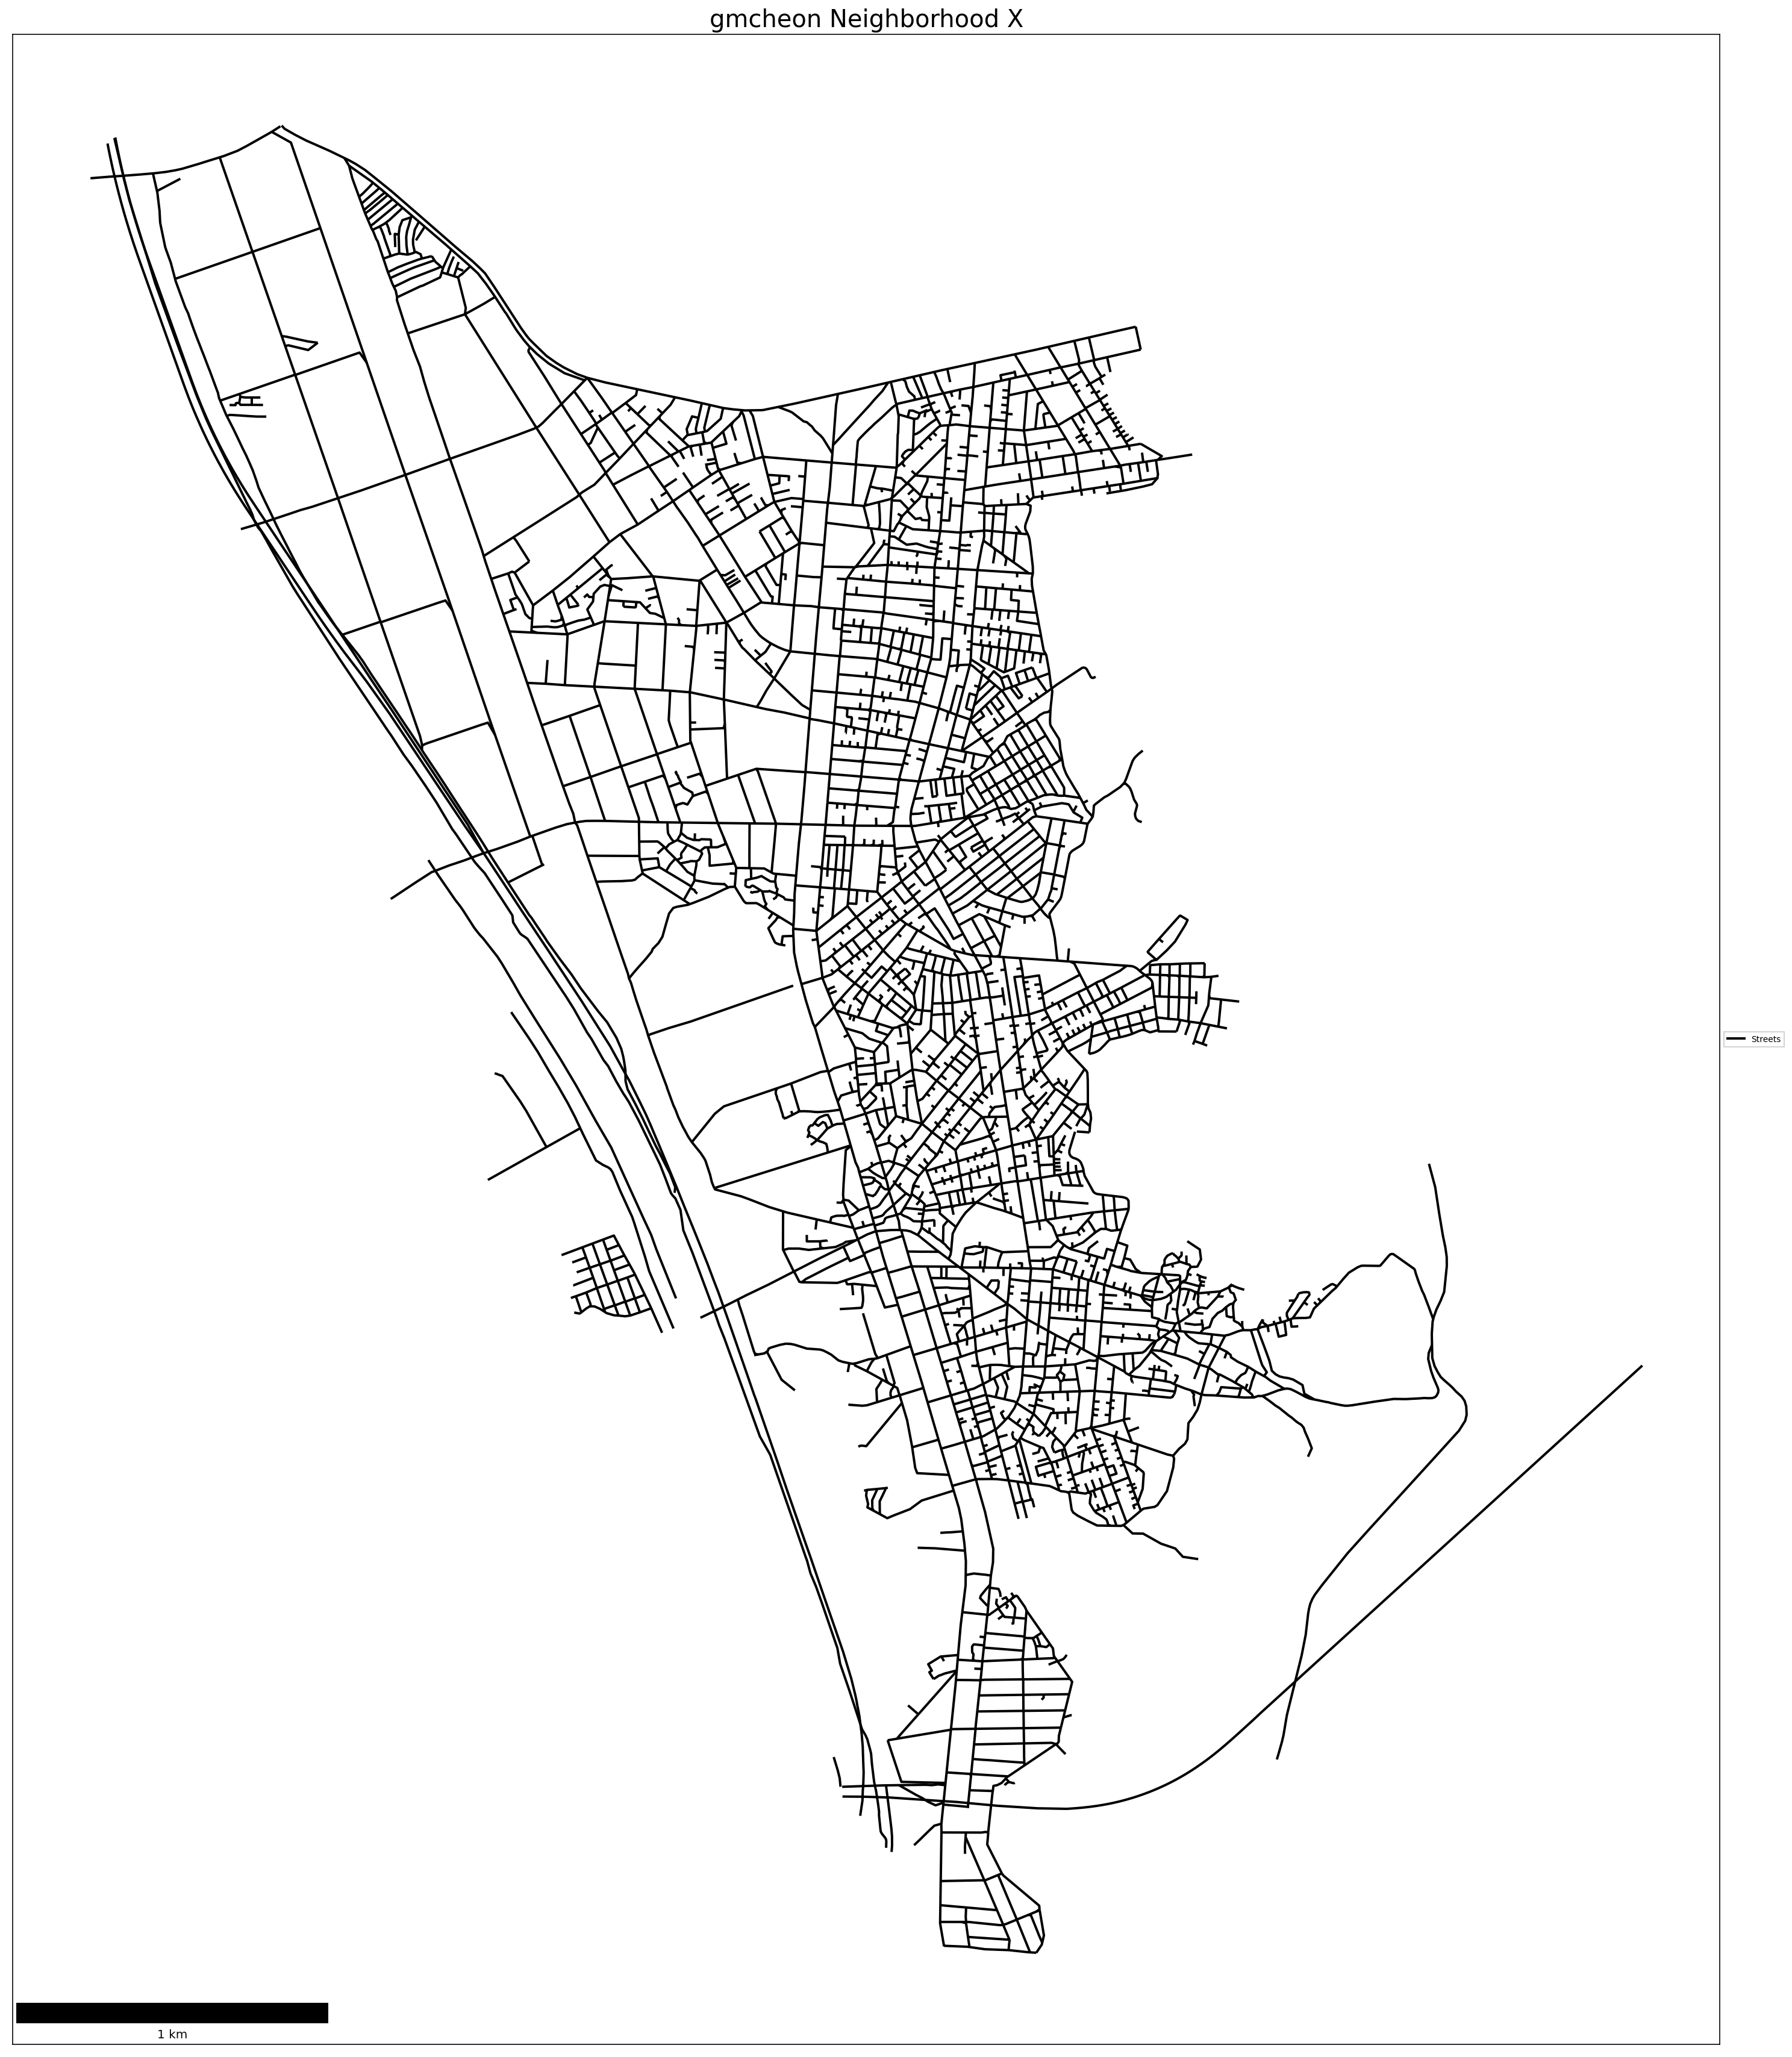

In [131]:
add_to_plot = {"streets": gangnam_streets}
plotter(plot_aux=add_to_plot, pt1_size=60, title=title, figsize=(24, 24))

In [132]:
buff = 30
streets_buffer = get_buffer(gangnam_streets, buff=buff)
streets_buffer

geometry
0  POLYGON ((946202.133 1939376.535, 946199.648 1...

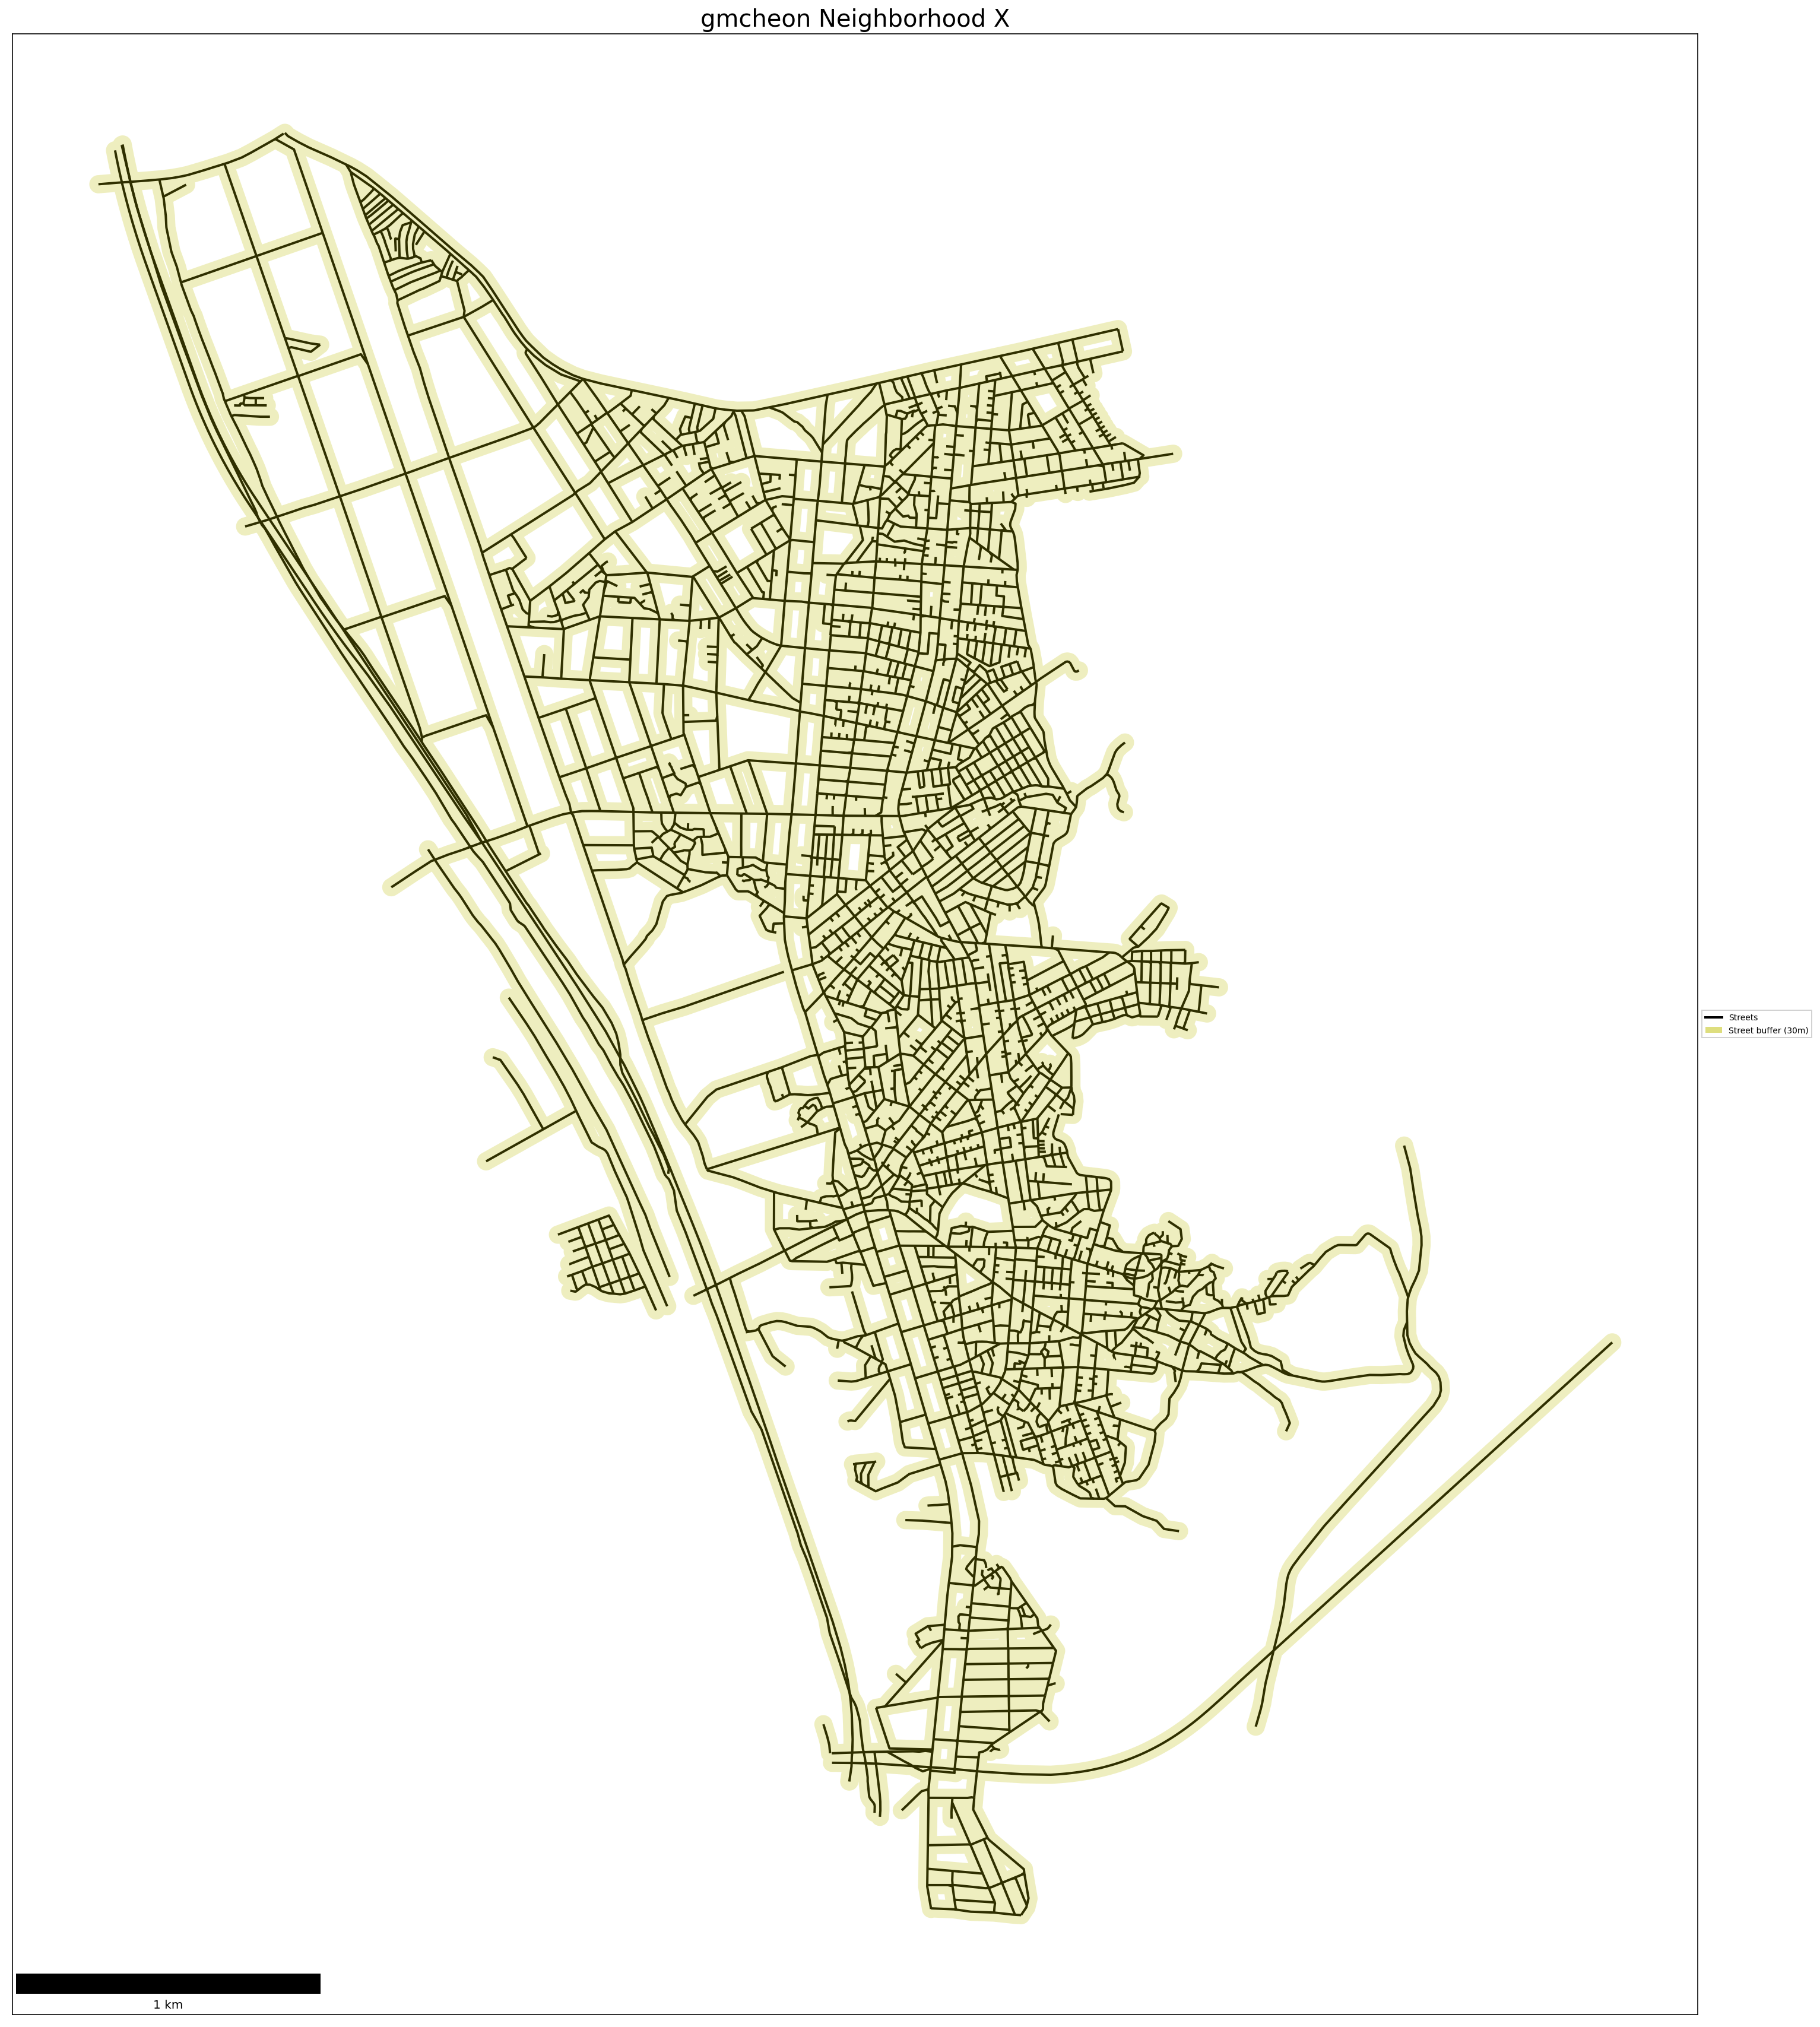

In [133]:
add_to_plot = {"streets": gangnam_streets, "buffer": streets_buffer}
plotter(plot_aux=add_to_plot, buffered=buff, title=title, figsize=(24, 24))

In [219]:
streets = gangnam_streets
clients = gangnam_clients
facilities = gangnam_facility[:30]

In [220]:
clients["dv"] = ["x[%s]" % c for c in range(client_count)]
facilities["dv"] = ["y[%s]" % c for c in range(30)]

c:\Users\chldl\Desktop\공부\공모전\통계데이터활용경진대회\Codespace\statics\lib\site-packages\geopandas\geodataframe.py:1456: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
add_to_plot = {
    "streets": streets,
    "buffer": streets_buffer,
    "cli_tru": clients,
    "fac_tru": facilities,
}
plotter(plot_aux=add_to_plot, buffered=buff, pt1_size=60, figsize=(24, 24))

In [71]:
weights = pd.read_csv("PreprocessData\weights.csv")

In [72]:
weights.rename(columns= {'Unnamed: 0' : 'SIG_KOR_NM'}, inplace=True)

In [221]:
clients = pd.merge(left = clients , right = weights, how = "inner", on = "SIG_KOR_NM")

In [222]:
numpy.random.seed(1991)
clients["weights"] = clients["필요도"]
clients.head(1)

SIG_KOR_NM                     도로명주소  도로명우편번호             사업장명  업태구분명  \
0        금천구  서울특별시 구로구 구로동로 16 (가리봉동)   8384.0  (주)코리아세븐 가리봉중앙점    NaN   

         좌표정보(X)        좌표정보(Y)  판매점영업면적                        geometry  \
0  189945.836463  442337.031761      NaN  POINT (945558.935 1942837.140)   

     dv  심야약국      인구밀도     노년부양비  유년부양비    노령화지수        병원      종합병원  \
0  x[0]   0.0  0.108847  0.028195    0.0  0.04938  0.033861  0.067725   

   weights   필요도  
0     99.0  99.0

In [141]:
ntw = spaghetti.Network(in_data=streets)

In [142]:
ntw.snapobservations(clients, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="clients", snapped=True
)
ntw.snapobservations(facilities, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="facilities", snapped=True
)

In [ ]:
add_to_plot = {
    "streets": streets,
    "buffer": streets_buffer,
    "cli_tru": clients,
    "fac_tru": facilities,
    "cli_snp": clients_snapped,
    "fac_snp": facilities_snapped,
}
plotter(plot_aux=add_to_plot, buffered=buff, pt1_size=60, pt2_size=25, figsize=(24, 24))

In [144]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)
cost_matrix[:3, :3]

cost_matrix2 = cost_matrix
import numpy as np
np.nan_to_num(cost_matrix2, copy=False)

array([[1026.07381989,  474.15191927,  524.14376149],
       [1112.6353865 ,  470.25991001,  414.06884502],
       [ 588.70979133,  385.90569384,  892.70394379]])

In [223]:
mclp = FacilityLocationModel(
    "mclp", ai=clients["weights"], cij=cost_matrix, p=3, s=max_coverage
)
clients, facilities = add_results(mclp, clients, facilities)

Solve Time: 0.001166669 minutes
Obj. Value: 16038.0 residents within 3500.000000 meters of 3 selected facilities
Percent of 17919 clients covered: 89.502762
--- 19 clients are not covered
--- 162 clients are covered by 1 facility
--- 117 clients are covered by 2 facilities


C:\Users\chldl\AppData\Local\Temp\ipykernel_46532\2732837685.py:112: RuntimeWarning: overflow encountered in multiply
  self.sij = self.ai * self.cij
c:\Users\chldl\Desktop\공부\공모전\통계데이터활용경진대회\Codespace\statics\lib\site-packages\geopandas\geodataframe.py:1456: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\chldl\AppData\Local\Temp\ipykernel_46532\2732837685.py:483: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name].fillna("closed", inplace=True)


In [163]:
def dv_colorset(dvs):
    """decision variables color set
    Parameters
    ---------
    dvs : geopandas.GeoSeries
        facility decision variables
    Returns
    -------
    dv_colors : dict
        decision variable to set color lookup
    """
    dv_colors = [
        'azure',
        'aquamarine',
        'mintcream', 
        "firebrick",
        "silver",
        "mediumseagreen",
        "blueviolet",
        "aqua",
        "crimson",
        "cyan",
        "limegreen",
        "snow",
        "mintcream",
        "lemonchiffon",
        "lightcoral",
        "peachpuff",
        "mediumvioletred",
        "salmon",
        "rebeccapurple",
        "rebeccapurple",
        "ivory",
        "lavenderblush",
        "deeppink",
        "darkmagenta",
        "olive",
        "indigo",
        "cornsilk",
        "cornflowerblue",
        "red",
        "cadetblue",
        'plum',
        'springgreen',
        'dodgerblue',
        'palevioletred',
        'hotpink',
        'darkviolet',
        'mediumslateblue',
        'navy',
        'midnightblue',
        'cornflowerblue',
        'aliceblue',
        'steelblue',
        'darkcyan',
        'teal',
        'darkcyan',
    ]
    
    # dv_colors2 = {}
    # fac = 0
    # idx = 0
    # while idx < len(dvs):
    #     dv_colors2[dvs[fac]] = dv_colors[idx]
    #     fac += 1
    #     idx += 1
    #     if idx == 15:
    #         idx = 0
            
    dv_colors = {dv: dv_colors[idx] for idx, dv in enumerate(dvs)}
    return dv_colors

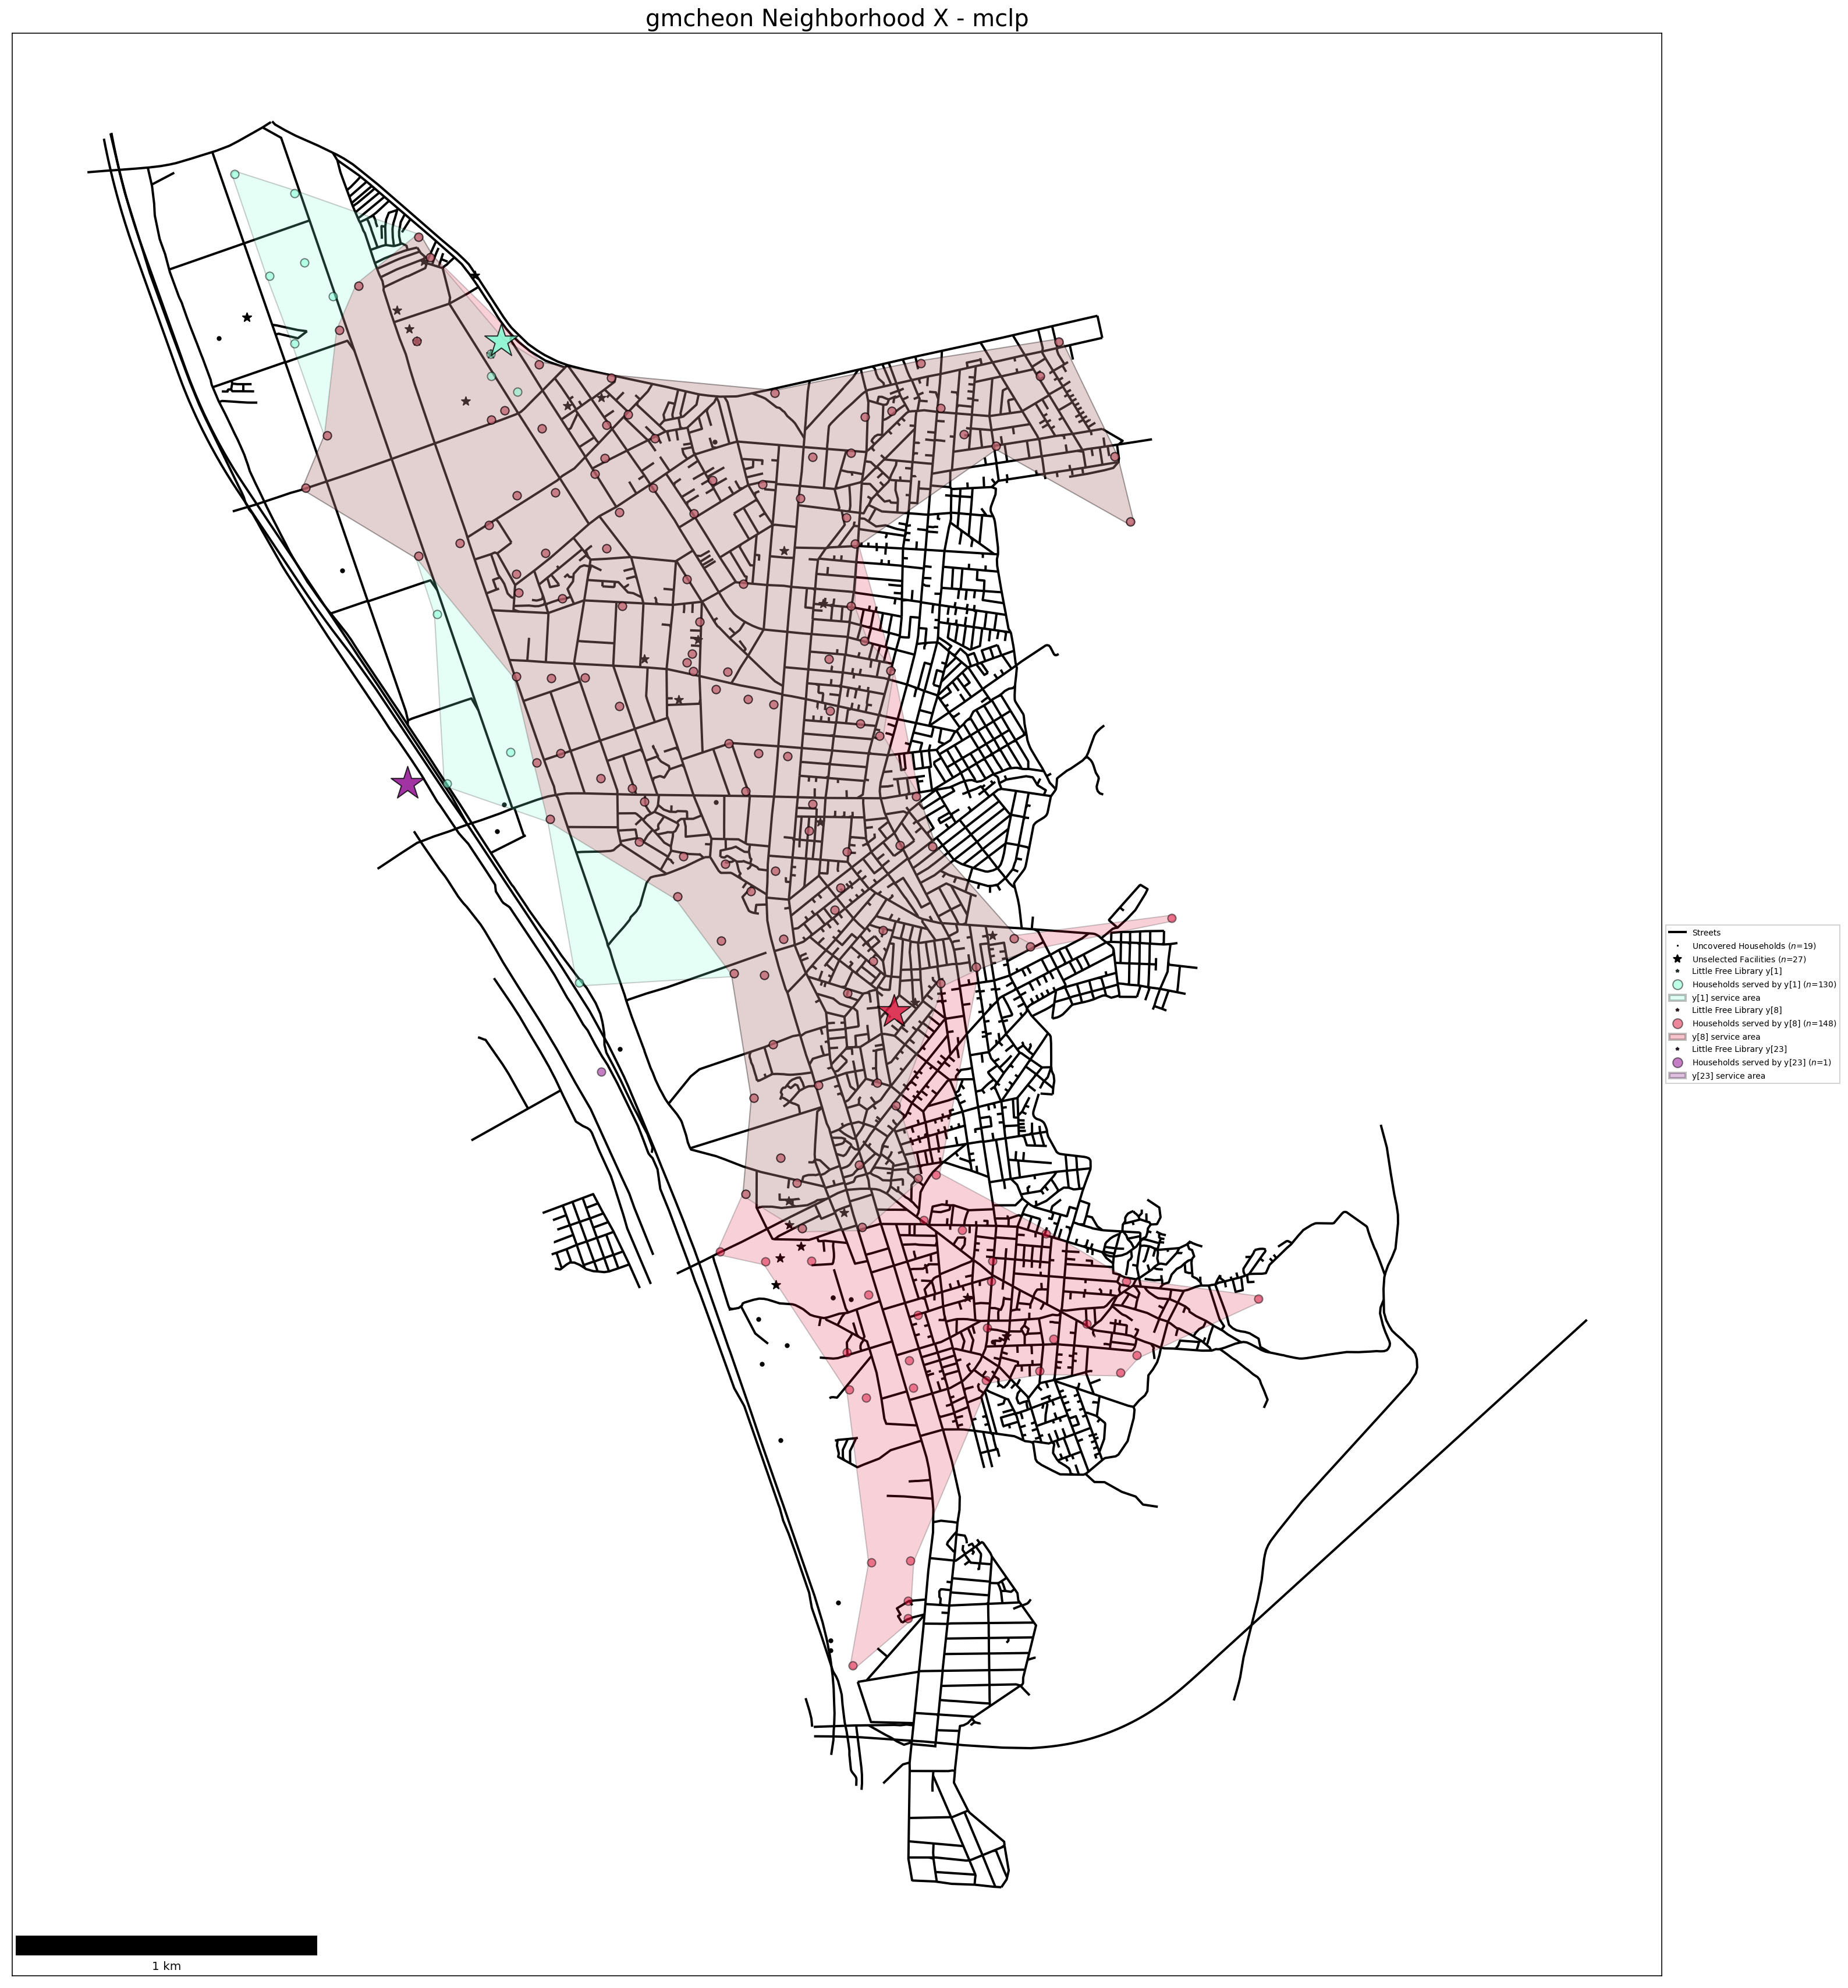

In [224]:
aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
    figsize = (24, 24)
)

In [ ]:
models = [pmp, pcp, mclp]

In [ ]:
analytics_df, analytics_display = analytics_matrix(models)
analytics_display

ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
md(f"While it appears the `{mclp.name}` performs most optimally with the least distance per stastistic, we have to remember that the `{mclp.name}` is leaving `{mclp.n_cli_uncov}` clients uncovered. Therefore, it may generally give lower maximum and average travel costs due to the uncovered client travel costs being excluded.")

While it appears the `mclp` performs most optimally with the least distance per stastistic, we have to remember that the `mclp` is leaving `331` clients uncovered. Therefore, it may generally give lower maximum and average travel costs due to the uncovered client travel costs being excluded.

In [ ]:
selection_df, selection_display = selection_matrix(models)
selection_display

In [ ]:
usr_warning = "The GeoDataFrame you are attempting to plot is empty"
warnings.filterwarnings("ignore", message=usr_warning)

# facility variable-to-times selected lookup
fac2selectcount = dict(selection_df["$\sum$"].astype(int))
aux_to_plot = {"streets": streets, "cli_tru": clients}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
multi_plotter(
    models,
    plot_aux=aux_to_plot,
    title=title,
    plot_res=res_to_plot,
    select=fac2selectcount,
)

ValueError: cannot reshape array of size 3 into shape (2,2)

In [ ]:
v1 = pcp.name
v2 = str(list(pcp.fac2cli.keys())).translate({ord(r"'"): None})
v3 = analytics_df.loc[(analytics_df["stats"] == "abs_max"), "pcp"].squeeze()
v4 = max_coverage
md(f"* The `{v1}` model facility configuration: `{v2}` \n\
* This configuration results in an absolute maximum distance from any household to its assigned Little Free Library of `{v3}` meters, which is slightly more than the `{v4}` meter maximum distance stipulation put forth by the committee. Dr. Minimax believes this to be the most equitable and feasible solution for the residents of Neighbor X. However..., the Neighborhood X Planning Committee turned out to be corrupt and merely chose locations for the Little Free Libraries nearest to their respective houses....")

NameError: name 'analytics_df' is not defined

In [192]:
facilities.columns

Index(['EMD_CD', 'EMD_KOR_NM', 'SIG_KOR_NM', '사업장명', '경도', '위도', 'geometry',
       'dv', 'pmp_sol', 'pcp_sol', 'mclp_sol'],
      dtype='object')

In [208]:
facilities

[1      True
 8     False
 23    False
 Name: 사업장명, dtype: bool]

In [233]:
facilities[facilities["mclp_sol"] != "closed"][['사업장명', 'mclp_sol']]

사업장명                                           mclp_sol
1      자명약국  [x[0], x[1], x[2], x[3], x[4], x[5], x[9], x[1...
8   현대온누리약국  [x[0], x[1], x[2], x[3], x[5], x[6], x[7], x[8...
23     가람약국                                           [x[166]]

In [232]:
facilities

EMD_CD EMD_KOR_NM SIG_KOR_NM     사업장명             경도             위도  \
0   11545101        가산동        금천구     동성약국  190134.346813  442210.419030   
1   11545101        가산동        금천구     자명약국  190223.799551  441992.692586   
2   11545101        가산동        금천구     구림약국  190188.948658  441950.139213   
3   11545101        가산동        금천구     한중약국  189965.118530  442256.168149   
4   11545102        독산동        금천구  독산메디칼약국  191290.582375  440402.040127   
5   11545103        시흥동        금천구    비타민약국  191863.813276  440027.754204   
6   11545102        독산동        금천구    행복한약국  190704.904313  440940.384414   
7   11545101        가산동        금천구     하얀약국  190556.730217  441806.805666   
8   11545103        시흥동        금천구  현대온누리약국  191538.228352  439773.967202   
9   11545103        시흥동        금천구   아이사랑약국  191234.143902  438993.253765   
10  11545103        시흥동        금천구     동백약국  191376.965877  439105.872925   
11  11545101        가산동        금천구   참사랑한약국  190444.218182  441779.879723   
12  11545101        가산동        금천구     봄빛약국  189378.332494  442066.998665   
13  11545101        가산동        금천구  가디온누리약국  189378.332494  442066.998665   
14  11545103        시흥동        금천구     우리약국  191164.104918  438953.968599   
15  11545101        가산동        금천구  드림플러스약국  189943.546219  441990.817437   
16  11545103        시흥동        금천구     마미약국  191917.450108  438699.774609   
17  11545103        시흥동        금천구      수약국  191152.432649  438865.160717   
18  11545101        가산동        금천구  가산소중한약국  189877.178944  442093.648597   
19  11545101        가산동        금천구    새우리약국  190106.784904  441792.675618   
20  11545101        가산동        금천구     라임약국  189917.493331  442031.656022   
21  11545102        독산동        금천구     조은약국  190880.477054  441004.490707   
22  11545102        독산동        금천구    대제일약국  191295.623662  441127.210171   
23  11545101        가산동        금천구     가람약국  189920.528611  440521.855249   
24  11545102        독산동        금천구     다원약국  191166.287524  441302.206536   
25  11545103        시흥동        금천구     다해약국  191786.988598  438826.884783   
26  11545103        시흥동        금천구     바다약국  191191.868732  439144.877856   
27  11545103        시흥동        금천구    세명당약국  191195.659642  439065.169432   
28  11545103        시흥동        금천구    남대문약국  191609.058323  439805.420698   
29  11545102        독산동        금천구     여름약국  190818.572504  440806.286184   

                          geometry     dv pmp_sol pcp_sol  \
0   POINT (945746.698 1942709.572)   y[0]  closed  closed   
1   POINT (945834.958 1942491.454)   y[1]  closed  closed   
2   POINT (945799.894 1942449.103)   y[2]  closed  closed   
3   POINT (945577.779 1942756.205)   y[3]  closed  closed   
4   POINT (946892.861 1940895.741)   y[4]  closed  closed   
5   POINT (947463.878 1940518.551)   y[5]  closed  closed   
6   POINT (946310.275 1941436.993)   y[6]  closed  closed   
7   POINT (946166.770 1942303.867)   y[7]  closed  closed   
8   POINT (947137.069 1940266.595)   y[8]  closed  closed   
9   POINT (946828.949 1939487.803)   y[9]  closed  closed   
10  POINT (946972.315 1939599.618)  y[10]  closed  closed   
11  POINT (946054.158 1942277.551)  y[11]  closed  closed   
12  POINT (944990.213 1942570.232)  y[12]  closed  closed   
13  POINT (944990.213 1942570.232)  y[13]  closed  closed   
14  POINT (946758.729 1939448.905)  y[14]  closed  closed   
15  POINT (945554.803 1942491.071)  y[15]  closed  closed   
16  POINT (947510.429 1939190.803)  y[16]  closed  closed   
17  POINT (946746.588 1939360.194)  y[17]  closed  closed   
18  POINT (945489.009 1942594.216)  y[18]  closed  closed   
19  POINT (945716.924 1942292.138)  y[19]  closed  closed   
20  POINT (945528.977 1942532.033)  y[20]  closed  closed   
21  POINT (946486.121 1941500.140)  y[21]  closed  closed   
22  POINT (946901.759 1941620.603)  y[22]  closed  closed   
23  POINT (945523.976 1941022.800)  y[23]  closed  closed   
24  POINT (946773.405 1941796.220)  y[24]  closed  closed   
25  POINT (947380.694 1939318.55